# <center>The Distribution of Equity and Currency Returns</center>
#### <center> A Project Completed in COMP 370 under the guidance of Doug Turnbull </center>

# Background

### My interests:
 - Statistics, Probability, Machine Learning, Applied Mathematics
 - Computer Programming, Python, Data manipulation and analysis
 - Data Vizualization
  - an often overlooked but very important subject!
 - Financial Markets, Algorithmic Trading, Financial Mathematics

#### Data Science:
 - Statistics + Computer programming + Domain knowledge

In [79]:
def classify(arr):
    return 'data science!'

In [80]:
classify(['statistics', 'computer programming', 'domain knowledge'])

'data science!'

## My goals for the project:
 - Learn how to perform quantitative financial research
 - Learn the basic tools required for data science (Python tools in this case)
  - packages commonly used in industry
 - Produce something intersting and useful
  - Are Nassim Taleb and others telling the truth? (yes)
 - practice using some statistics

# Topic: Return Distributions
### Why returns? Why not just price?
 - A $\$10$ increase in a $\$10$ stock is much more than a $\$10$ increase in a $\$100$ stock
  - we can compare with the return (percent change) between periods

- We will actually use the logarithmic return (rate of continuous compounding return)

$$ r_{i} = ln\left(\frac{P_{i}}{P_{i-1}}\right) $$
 - for price **$P$**, return **$r$**, and period **$i$**

 - this is very helpful because
 $$\sum_{j=1}^{n}r_{j} = r_{1} + r_{2} + ... + r_{n} = r_{N}$$
 - The return in period $N$ is the sum of the returns in its sub periods, unlike arithmetic returns
 - The sum of repeated samples from a normal distribution is normally distributed
  - as you will see we aren't going to assume normallity
 $$ln\left(\frac{100}{50}\right) = - ln\left(\frac{50}{100}\right) \approx 69.3\%$$

# Topic: Return Distributions
### Why look at return distributions? Aren't returns just... returns?
 

 - Value at Risk (**VaR**) model
  - attempts to estimate the probability of a specified size **loss** on a given portfolio of asset is a specified period
   - "What is the most I can lose today with $95\%$ confidence?"
  - Uses either historical or theoretical return distribution
   - It used to be the case that normal distributions were assumed!
    - somethimes still are, but less so

 - the **Black-Scholes** option pricing model assumes that asset prices follow an infinitesimal log-normal random walk

- **Harry Markowitz's Mean Variance Theory** (modern portfolio theory)
  - determines how to optimally construct a portfolio of assets
   - assumes market retuns are **independent and normally distributed**

# Topic: Return Distributions
## Why look at return distributions? Aren't returns just... returns?

### As Investors, we need to
 1. Understand what is at risk
  - worst case, how bad can it get?
 - Are assets priced correctly? 
  - Were the assumptions in the pricing model correct?
 - How can we construct an optimal portfolio
  - given a universe of assets

In [85]:
np.log((100)/50.0)

0.69314718055994529

In [86]:
np.log(50/100)

-0.69314718055994529

In [1]:
# Importing the libraries I anticipate using
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import pandas_datareader.data as web
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime
import scipy.stats as stats
import quandl
import time

%matplotlib inline

## More Data

To make the remaining work easier, I am going to design a `Data` class to interact with get get and store the data that I will be using. I will also be introducing currency data from the European Central Bank data on Quandl.

In [2]:
# get my quandl api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/quandl_api_key.txt', 'r')
key = f.read()
key = key.strip()
quandl.ApiConfig.api_key = key

In [3]:
data = quandl.get('ECB/EURUSD')
data.head()

Value
Date              
1999-01-04  1.1789
1999-01-05  1.1790
1999-01-06  1.1743
1999-01-07  1.1632
1999-01-08  1.1659

Unfortunately, Quandle seems to only have a few free sources for currency prices which each offer only a few pairs. I am going to try to get this data from foreign exchange broker Oanda.

In [4]:
# Python wrapper for oanda API, this wrapper needs some work but will do the job for now I think.
import oandapy as opy

# get my oada api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/oanda_api_key.txt', 'r')
key = f.read()
key = key.strip()

oanda = opy.API(environment='practice', access_token=key)

In [ ]:
# I am going to try to get minutely data form oanda, 
# I have to do it in chuncks because they have a 5000 limit for each request

start = '2002-05-05'
end = '2016-07-01'

dates = pd.date_range(start=start, end=end, freq='D')
instrument = 'EUR_USD'
df = DataFrame()

print('fethcing data for ',instrument)
for i in range(0, len(dates) - 1):
    # Format of date required by oanda API
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i + 1]).replace(' ', 'T')

    try:
        d = oanda.get_history(instrument = instrument, start=d1, end=d2,
                                 alignmentTimezone='America/New_York', granularity='M5')
        df = df.append(DataFrame(d['candles']))
    except:
        pass

df = df.set_index('time')
df.index = [pd.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ") for x in df.index]
eur_usd = df

fethcing data for  EUR_USD


In [11]:
print(len(eur_usd))
eur_usd.head()


767332


closeAsk  closeBid complete  highAsk  highBid  lowAsk  \
2002-05-06 20:55:00    0.9184    0.9181     True   0.9184   0.9181  0.9184   
2002-05-07 20:55:00    0.9155    0.9152     True   0.9155   0.9152  0.9155   
2002-05-08 20:55:00    0.9045    0.9042     True   0.9045   0.9042  0.9045   
2002-05-09 20:55:00    0.9095    0.9092     True   0.9095   0.9092  0.9095   
2002-05-10 20:55:00    0.9145    0.9135     True   0.9145   0.9135  0.9145   

                     lowBid  openAsk  openBid  volume  
2002-05-06 20:55:00  0.9181   0.9184   0.9181       1  
2002-05-07 20:55:00  0.9152   0.9155   0.9152       1  
2002-05-08 20:55:00  0.9042   0.9045   0.9042       1  
2002-05-09 20:55:00  0.9092   0.9095   0.9092       1  
2002-05-10 20:55:00  0.9135   0.9145   0.9135       1

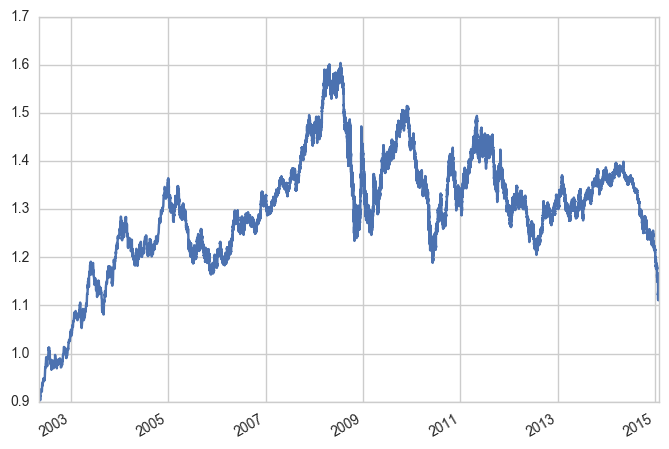

In [15]:
style.use('seaborn-notebook')

eur_usd.closeAsk.plot();

In [55]:
%%time
# I am going to try to get minutely data form oanda, 
# I have to do it in chuncks because they have a 5000 limit for each request

start = '2002-05-05'
end = '2016-07-01'

dates = pd.date_range(start=start, end=end, freq='6M')
instrument = 'EUR_USD'
df = DataFrame()

print('fethcing data for ',instrument)
for i in range(0, len(dates) - 1):
    # Format of date required by oanda API
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i + 1]).replace(' ', 'T')

    try:
        d = oanda.get_history(instrument = instrument, start=d1, end=d2,
                                 alignmentTimezone='America/New_York', granularity='H1')
        df = df.append(DataFrame(d['candles']))
    except:
        pass

df = df.set_index('time')
df.index = [pd.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ") for x in df.index]
e_u = df

fethcing data for  EUR_USD
CPU times: user 2.51 s, sys: 128 ms, total: 2.63 s
Wall time: 10 s


In [52]:
start = '2002-05-05'
end = '2016-07-01'

dates = pd.date_range(start=start, end=end, freq='9M')

In [53]:
len(dates)

19

In [56]:
print(len(e_u))
e_u.tail()

74483


closeAsk  closeBid complete  highAsk  highBid   lowAsk  \
2016-05-30 19:00:00   1.11414   1.11401     True  1.11431  1.11409  1.11371   
2016-05-30 20:00:00   1.11400   1.11358     True  1.11428  1.11408  1.11378   
2016-05-30 21:00:00   1.11365   1.11336     True  1.11407  1.11372  1.11363   
2016-05-30 22:00:00   1.11428   1.11409     True  1.11429  1.11410  1.11354   
2016-05-30 23:00:00   1.11484   1.11469     True  1.11504  1.11488  1.11428   

                      lowBid  openAsk  openBid  volume  
2016-05-30 19:00:00  1.11352  1.11384  1.11366     270  
2016-05-30 20:00:00  1.11352  1.11420  1.11402     309  
2016-05-30 21:00:00  1.11326  1.11401  1.11363     116  
2016-05-30 22:00:00  1.11335  1.11356  1.11338     359  
2016-05-30 23:00:00  1.11412  1.11429  1.11412     349

In [3]:
# Available instruments to trade

accts = oanda.get_accounts()
acct_id = accts['accounts'][0]['accountId']
ins = oanda.get_instruments(account_id=acct_id)['instruments']
ins_list = []
for i in ins:
    ins_list.append(i['instrument'])
    print(i['instrument'], end=', ')

AUD_CAD, AUD_CHF, AUD_HKD, AUD_JPY, AUD_NZD, AUD_SGD, AUD_USD, CAD_CHF, CAD_HKD, CAD_JPY, CAD_SGD, CHF_HKD, CHF_JPY, CHF_ZAR, EUR_AUD, EUR_CAD, EUR_CHF, EUR_CZK, EUR_DKK, EUR_GBP, EUR_HKD, EUR_HUF, EUR_JPY, EUR_NOK, EUR_NZD, EUR_PLN, EUR_SEK, EUR_SGD, EUR_TRY, EUR_USD, EUR_ZAR, GBP_AUD, GBP_CAD, GBP_CHF, GBP_HKD, GBP_JPY, GBP_NZD, GBP_PLN, GBP_SGD, GBP_USD, GBP_ZAR, HKD_JPY, NZD_CAD, NZD_CHF, NZD_HKD, NZD_JPY, NZD_SGD, NZD_USD, SGD_CHF, SGD_HKD, SGD_JPY, TRY_JPY, USD_CAD, USD_CHF, USD_CNH, USD_CZK, USD_DKK, USD_HKD, USD_HUF, USD_JPY, USD_MXN, USD_NOK, USD_PLN, USD_SAR, USD_SEK, USD_SGD, USD_THB, USD_TRY, USD_ZAR, ZAR_JPY, 

I am able to get all of the currency data that I need from Oanda.

## Constructing the Data Object

The `Data` object, with which I will interact, holds onto the `Currencies` and and `Equities` classes. The `Currencies` class organizes currencies by their base currency and holds onto a number of `Currency_Base` objects, each of which holds a number of `Currency_Pair` objects. The `Currency_Pair` object finds and holds the data for a unique currency pair. The `Equities` object hold onto two categories of `Equity` objects, ETFs and regular equities. It also has a few functions which can be used to make selections of different `Equity` objects. Each `Equitiy` object finds and holds data on a unique equity.

In [5]:

class Equity:
    """
    Retrieves and holds data for a single equity
    """
    def __init__(self, symbol, start='1990-01-01', end='today'):
        self.symbol = symbol
        start = start.split('-')
        start = datetime.date(int(start[0]), int(start[1]), int(start[2]))
        
        if end == 'today':
            end = datetime.date.today()
        else:
            end = end.split('-')
            end = datetime.date(int(end[0]), int(end[1]), int(end[2]))
            
        # See if this data is already stored on the disk
        with pd.HDFStore('project_data.h5') as store:
            try:
                self.pricing = store["/equities/"+symbol+"/pricing"]
                if len(self.actions.index) > 0:
                    self.adj_pricing = store["/equities/"+symbol+"/adj_pricing"]
                self.returns = store["/equities/"+symbol+"/returns"].dropna(how='all')
                self.actions = strore['/equities/'+symbol+'/actions']
                self.start = self.pricing.index[0]
                self.end = self.pricing.index[-1]
            except:
                self.pricing = web.DataReader(self.symbol,'yahoo', start, end)
                store["/equities/"+symbol+"/pricing"] = self.pricing
                self.start = self.pricing.index[0]
                self.end = self.pricing.index[-1]
                self.actions = web.DataReader(self.symbol, 'yahoo-actions', self.start, self.end)
                store['/equities/'+symbol+'/actions'] = self.actions
                if len(self.actions.index) > 0:
                    self.add_adjusted_data()
                    store["/equities/"+symbol+"/adj_pricing"] = self.adj_pricing
                self.returns = np.log(1 + self.pricing['Adj Close'].pct_change())[1:]
                store["/equities/"+symbol+"/returns"] = self.returns
                
    def __repr__(self):
        return "Equity Object: "+self.symbol

        
        
    def add_adjusted_data(self):
        """
        Calculates and adds split adjusted price data as self.adj_pricing.

        Uses yahoo-actions data to determine when and how much stock plits were,
        if they have occured. The initial data are adjusted for the splits,
        with the exception of the Adj Close and Volume which have already been adjusted.
        Adds adjust data as self.adj_pricing
        """
        splits = self.actions[self.actions.action == 'SPLIT']
        self.adj_pricing = self.pricing.copy()
        if len(splits.index) > 0:
            # Find the index and date of the split
            split_idxs = {i:x for i,x in enumerate(self.adj_pricing.index.tolist()) if x in splits.index}
            columns = self.adj_pricing.columns.tolist()

            # adjust for the splits
            for idx, date in split_idxs.items():
                for col in range(len(columns)):
                    if columns[col] != 'Volume' and columns[col] != 'Adj Close':
                        # adjust the prices of the shares
                        self.adj_pricing.iloc[:idx, col] = self.adj_pricing.iloc[:idx, col]*splits.loc[date].value

class Equities:
    """
    Holds Equity Objects and data as attributes.
    """
    def __init__(self):
        with pd.HDFStore('project_data.h5') as store:
            self.equity_market_caps = store['market_cap_sr']
            try:
                self.removed_symbols = store['removed_symbols']
            except:
                self.removed_symbols = Series([])
                store['removed_symbols'] = self.removed_symbols
        self.equity_symbols = list(self.equity_market_caps.keys())
        self.ETFs = {'SPY': Equity('SPY'), 'IWM': Equity('IWM'), 'QQQ': Equity('QQQ'),
                     'DIA': Equity('DIA'), 'VTI': Equity('VTI')}
        
        self.equities = {}
        
    def __repr__(self):
        return ("Equities Object, Number of Equities: "+str(len(self.equity_symbols))
                +", Number of ETFs: "+str(len(self.ETFs.keys())))
        
    def get_equity(self, symbol):
        """
        Gets and the Equity object for a specific symbol.
        
        If the data for the Equity object does not exist, the Equity is created if possible.
        If the Equity data cannot be found, will return None, otherwise will return the Equity.
        """
        if symbol in self.equities.keys():
            return self.equities[symbol]
        elif symbol in self.ETFs.keys():
            return self.ETFs[symbol]
        elif symbol in self.equity_symbols:
            try:
                new_equity = Equity(symbol)
                self.equities[symbol] = new_equity
                return new_equity
            except Exception as e:
                #print('Could not retrieve data for this symbol '+symbol
                #      +", removing symbol and selecting a new one")
                # Remove bad symbol
                self.equity_symbols.remove(symbol)
                self.equity_market_caps = self.equity_market_caps[self.equity_market_caps.index != symbol]
                self.removed_symbols = self.removed_symbols.append(Series([symbol],
                                                                          index=[self.removed_symbols.shape[0]]))
                
                return None
        else:
            print('Data unavailable for ',symbol)
            return None
        
            
    def random_selection(self, size=1, include_ETFs=False):
        """
        Returns a random selection of equity objects of the specified size.
        
        Chosen without replacement. include_ETFs=False by default, set to True to inclue ETFs.
        Will return None if size < 1
        """
        size = int(size)
        if include_ETFs:
            symbols = list(np.random.choice(self.equity_symbols + list(self.ETFs.keys())
                                            , size=size, replace=False))
        else:
            symbols = list(np.random.choice(self.equity_symbols, size=size, replace=False))
        if size > 0:
            selections = []
            for i in range(size):
                eq = self.get_equity(symbols[i])
                while eq == None:
                    if include_ETFs:
                        new_symbol = list(np.random.choice(self.equity_symbols + list(self.ETFs.keys()),
                                                        size=1, replace=False))[0]
                    else:
                        new_symbol = list(np.random.choice(self.equity_symbols, size=1, replace=False))[0]
                    if new_symbol not in symbols:
                        symbols[i] = new_symbol
                        eq = self.get_equity(new_symbol)
                selections.append(eq)
            return selections
        return None
                    
        
        
    def __del__(self):
        """
        Stores the updated market_cap_sr Series
        """
        with pd.HDFStore('project_data.h5') as store:
            try:
                store['market_cap_sr'] = self.equity_market_caps
                store['removed_symbols'] = self.removed_symbols
            except:
                pass
        
        
class Currency_Pair:
    def __init__(self, base, quote, oanda):
        self.pair_name = quote+'/'+base
        # "no more than 120 requests per second on average, with bursts of no more than 60 requests"
        # add random delay to prevent request rejection
        time.sleep(np.random.randint(2,10))
        
        # Check disk for existing data, if nothing, then download
        with pd.HDFStore('project_data.h5') as store:
            try:
                self.pricing = store['/Currencies/Oanda/'+base+'/'+quote+'/pricing']
                self.returns = store['/Currencies/Oanda/'+base+'/'+quote+'/returns'].dropna(how='all')
            except:
                start = '2002-05-05' # first day oanda's currency data
                end = '2017-01-07'
                
                # I have to split it in chuncks because they have a 5000 limit for each request
                dates = pd.date_range(start=start, end=end, freq='6M')
                instrument = quote+'_'+base
                df = DataFrame()

                for i in range(0, len(dates) - 1):
                    # Format of date required by oanda API
                    d1 = str(dates[i]).replace(' ', 'T')
                    d2 = str(dates[i + 1]).replace(' ', 'T')

                    try:
                        d = oanda.get_history(instrument = instrument, start=d1, end=d2,
                                                 alignmentTimezone='America/New_York', granularity='H1')
                        df = df.append(DataFrame(d['candles']))
                    except:
                        pass
                if len(df) > 0:
                    df = df.set_index('time')
                    df.index = [pd.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ") for x in df.index]
                    self.pricing = df

                    self.returns = np.log(1 + self.pricing.closeAsk.pct_change())[1:]
                    store['/Currencies/Oanda/'+base+'/'+quote+'/pricing'] = self.pricing
                    store['/Currencies/Oanda/'+base+'/'+quote+'/returns'] = self.returns
                    print('Successfully downloaded ',quote,'/',base,' from oanda.')
        
        self.start = self.pricing.index[0]
        self.end = self.pricing.index[-1]
        
    def __repr__(self):
        return "Currency Pair: "+self.pair_name
               
            
class Currency_Base:
    def __init__(self, base, oanda_key):
        source = 'Oanda' # European Central Bank
        self.base = base
        self._list = []
        
        time.sleep(2)
        oanda = opy.API(environment='practice', access_token=oanda_key)
        
        # get a list of available instruments from oanda
        accts = oanda.get_accounts()
        acct_id = accts['accounts'][0]['accountId']
        ins = oanda.get_instruments(account_id=acct_id)['instruments']
        ins_list = []
        for i in ins:
            ins_list.append(i['instrument'])
        ins_list
        
        if base != 'EUR' and 'EUR_'+base in ins_list:
            try:
                self.EUR = Currency_Pair(self.base, 'EUR', oanda)
                self._list.append(self.EUR)
            except:
                pass
        if base != 'USD' and 'USD_'+base in ins_list:
            try:
                self.USD = Currency_Pair(self.base, 'USD', oanda)
                self._list.append(self.USD)
            except:
                pass
        if base != 'GBP' and 'GBP_'+base in ins_list:
            try:
                self.GBP = Currency_Pair(self.base, 'GBP', oanda)
                self._list.append(self.GBP)
            except:
                pass
        if base != 'CAD' and 'CAD_'+base in ins_list:
            try:
                self.CAD = Currency_Pair(self.base, 'CAD', oanda)
                self._list.append(self.CAD)
            except:
                pass
        if base != 'AUD' and 'AUD_'+base in ins_list:
            try:
                self.AUD = Currency_Pair(self.base, 'AUD', oanda)
                self._list.append(self.AUD)
            except:
                pass
        if base != 'JPY' and 'JPY_'+base in ins_list:
            try:
                self.JPY = Currency_Pair(self.base, 'JPY', oanda)
                self._list.append(self.JPY)
            except:
                pass
        if base != 'CHF' and 'CHF_'+base in ins_list:
            try:
                self.CHF = Currency_Pair(self.base, 'CHF', oanda)
                self._list.append(self.CHF)
            except:
                pass
        if base != 'NZD' and 'NZD_'+base in ins_list:
            try:
                self.NZD = Currency_Pair(self.base, 'NZD', oanda)
                self._list.append(self.NZD)
            except:
                pass
            
    def __repr__(self):
        return "Base Currency: "+self.base
    
    def __iter__(self):
        self.iter_n = 0
        return self

    def __next__(self):
        if self.iter_n < len(self._list):
            i = self.iter_n
            self.iter_n += 1
            return self._list[i]
        
        else:
            raise StopIteration
            
class Currencies:
    """
    Holds Currency_Base Objects.
    """
    def __init__(self, oanda_key):
        self.currency_list = ['EUR','USD','GBP','CAD','AUD','JPY','CHF','NZD']
        self.EUR = Currency_Base('EUR', oanda_key)
        self.USD = Currency_Base('USD', oanda_key)
        self.GBP = Currency_Base('GBP', oanda_key)
        self.CAD = Currency_Base('CAD', oanda_key)
        self.AUD = Currency_Base('AUD', oanda_key)
        self.JPY = Currency_Base('JPY', oanda_key)
        self.CHF = Currency_Base('CHF', oanda_key)
        self.NZD = Currency_Base('NZD', oanda_key)
        
    def __repr__(self):
        return "Currencies Object, Cross Rates for "+" ".join(self.currency_list)
    
    def __iter__(self):
        self.iter_n = 0
        return self

    def __next__(self):
        _list = [self.EUR, self.USD, self.GBP, self.CAD,
                 self.AUD, self.JPY, self.CHF, self.NZD]
        if self.iter_n < len(_list):
            i = self.iter_n
            self.iter_n += 1
            return _list[i]
        
        else:
            raise StopIteration
    
class Data:
    """
    Data object holds Currencies and Equities objects.
    """
    def __init__(self, oanda_key):
        self.currencies = Currencies(oanda_key)
        self.equities = Equities()
        
    def __repr__(self):
        return "Data Object, holds Equities and Currencies Objects."

Here I will initialize my new data object with which I will interact to get the data I will need. I there is other data that I will require, I will add it to the Data class.

In [6]:
# get my oada api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/oanda_api_key.txt', 'r')
key = f.read()
key = key.strip()

In [7]:
%%time
data = Data(key)

CPU times: user 1.32 s, sys: 282 ms, total: 1.6 s
Wall time: 2min 42s


In [6]:
print('Available Currency Pairs: ')
for currnecy in data.currencies:
    for pair in currnecy:
        print(pair.pair_name, end=', ')

Available Currency Pairs: 
EUR/USD, GBP/USD, AUD/USD, NZD/USD, EUR/GBP, EUR/CAD, USD/CAD, GBP/CAD, AUD/CAD, NZD/CAD, EUR/AUD, GBP/AUD, EUR/JPY, USD/JPY, GBP/JPY, CAD/JPY, AUD/JPY, CHF/JPY, NZD/JPY, EUR/CHF, USD/CHF, GBP/CHF, CAD/CHF, AUD/CHF, NZD/CHF, EUR/NZD, GBP/NZD, AUD/NZD, 

In [89]:
style.use('seaborn-whitegrid')
style.use('seaborn-notebook')

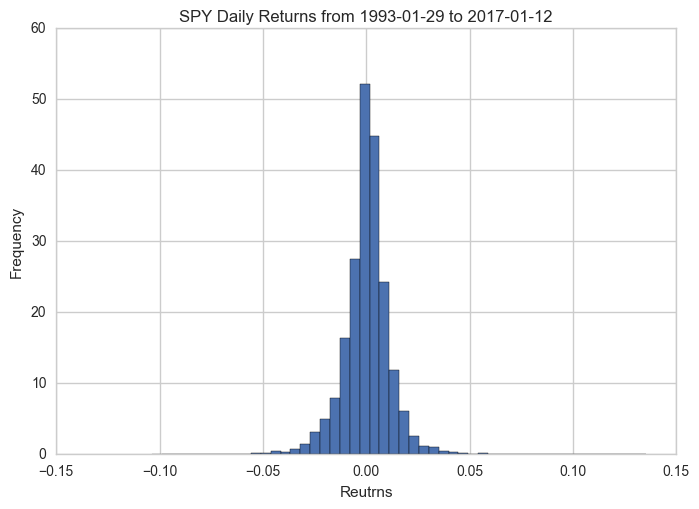

In [9]:
SPY = data.equities.ETFs['SPY']
SPY.returns.hist(bins=50, normed='true')
plt.xlabel('Reutrns')
plt.ylabel('Frequency')
plt.title('{0} Daily Returns from {1} to {2}'.format(SPY.symbol, SPY.start.date(), SPY.end.date()));

### Adjusting Time Frames

All of the equities data in the Data object have a daily frequency. The currency data, however, have an hourly frequency. Pandas DataFrames have a great built in function called `resample` that can return a sample of the data at a time frame larger than that of the underlying data. The pandas datetime object allows many different time frames including the following:

 - B - business day frequency
 - D - calendar day frequency
 - W - weekly frequency
 - M - month end frequency
 - SM - semi-month end frequency (15th and end of month)
 - A - year end frequency
 - H - hourly frequency
 - T - minutely frequency
 - S - secondly frequency

In [10]:
eur_jpy = data.currencies.JPY.EUR
# B for business days
eur_jpy.pricing.resample('B').first().head()

closeAsk  closeBid  complete  highAsk  highBid  lowAsk  lowBid  \
2002-05-31    116.06    115.96       1.0   116.06   115.96  116.06  115.96   
2002-06-03    116.33    116.29       1.0   116.33   116.29  116.33  116.29   
2002-06-04    116.64    116.60       1.0   116.64   116.60  116.64  116.60   
2002-06-05    116.88    116.84       1.0   116.88   116.84  116.88  116.84   
2002-06-06    117.62    117.58       1.0   117.62   117.58  117.62  117.58   

            openAsk  openBid  volume  
2002-05-31   116.06   115.96     1.0  
2002-06-03   116.33   116.29     1.0  
2002-06-04   116.64   116.60     1.0  
2002-06-05   116.88   116.84     1.0  
2002-06-06   117.62   117.58     1.0

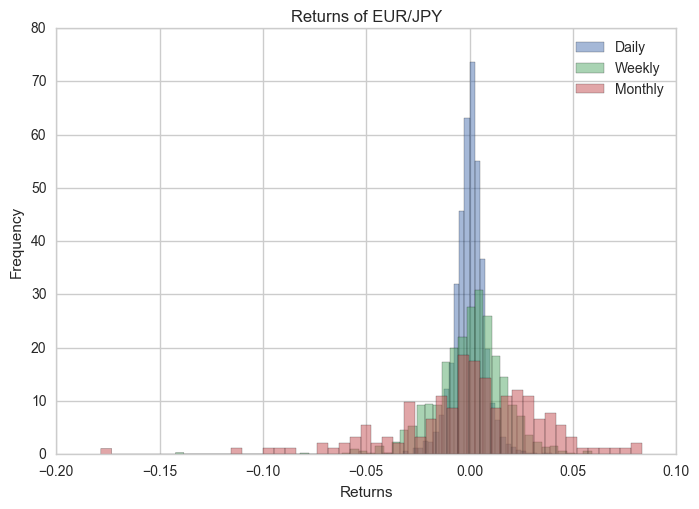

In [11]:
ej_daily_returns = np.log(1 + eur_jpy.pricing.resample('B').first().closeAsk.pct_change()).dropna()
ej_weekly_returns = np.log(1 + eur_jpy.pricing.resample('W').first().closeAsk.pct_change()).dropna()
ej_monthly_returns = np.log(1 + eur_jpy.pricing.resample('M').first().closeAsk.pct_change()).dropna()



plt.hist(ej_daily_returns, bins=50, alpha=0.5, normed=True, stacked=True, label='Daily')
plt.hist(ej_weekly_returns, bins=50, alpha=0.5, normed=True,stacked=True, label='Weekly')
plt.hist(ej_monthly_returns, bins=50, alpha=0.5, normed=True, stacked=True, label='Monthly')
plt.ylabel('Frequency')
plt.xlabel('Returns')
plt.title('Returns of '+eur_jpy.pair_name)
plt.legend();

With pandas `resample` function it is also possible to calculate OHLC values from the sample data for the new down sampled frequency. In finance, OHLC values are frequently used for various valulations and OHLC/Candlestick charts.

In [12]:
eur_jpy.pricing.closeAsk.resample('B').ohlc().tail()

open     high      low    close
2016-11-23  118.087  119.002  117.777  118.672
2016-11-24  118.555  119.710  118.555  119.632
2016-11-25  120.043  120.147  119.468  119.531
2016-11-28  119.408  119.476  118.597  118.597
2016-11-29  118.808  119.902  118.676  119.765

### Candlestick Charting for Financial Data

In [13]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from  matplotlib.finance import candlestick_ohlc

In [14]:
def candlestick_chart(asset, start=0, end=(-1), freq='B', volume=True):
    if type(start) != int:
        if not isinstance(start, pd.tslib.Timestamp):
            try:
                Y,m,d = [int(i) for i in start.split('-')]
                start = pd.datetime(Y,m,d)
            except:
                raise TypeError("Invalid type for start")
                return
        if start < asset.pricing.index[0]:
            start = asset.pricing.index[0]
        start = asset.pricing.index.get_loc(start)
    if type(end) != int:
        if not isinstance(end, pd.tslib.Timestamp):
            try:
                Y,m,d = [int(i) for i in end.split('-')]
                end = pd.datetime(Y,m,d)
            except:
                raise TypeError("Invalid type for end")
                return
        if end > asset.pricing.index[-1]:
            end = asset.pricing.index[-1]
        end = asset.pricing.index.get_loc(end)
            
        
    # Calculating resampled OHLC and new cumulative volume
    if isinstance(asset, Currency_Pair):
        # if asset is a currency
        if freq == 'H':
            ohlc = asset.pricing[['openAsk', 'highAsk','lowAsk','closeAsk', 'volume']]
            ohlc.rename(columns={'volume': 'Volume'}, inplace=True)
        else:
            ohlc = asset.pricing.closeAsk.resample(freq).ohlc()
            ohlc['Volume'] = asset.pricing.volume.resample(freq).sum()
    elif isinstance(asset, Equity):
        # if asset is equity
        if freq == 'B' or freq == 'D':
            ohlc = asset.pricing[['Open','High','Low','Close','Volume']]
        else:
            ohlc = asset.pricing.Close.resample(freq).ohlc()
            ohlc['Volume'] = asset.pricing.Volume.resample(freq).sum()

    # convert the index to datetime.datetime objects
    datetime_index = ohlc.index.to_pydatetime()
    # convert the datetime objects to matplotlib dateNums (similar to unix but + 1) a weird quirk
    date_nums = mdates.date2num(datetime_index)

    # add date column to ohlc values array
    ohlc_to_plot = np.insert(ohlc.values, 0, date_nums, axis=1)

    fig = plt.figure()
    if 'Volume' in ohlc.columns and volume:
        ax1 = plt.subplot2grid((5,4), (0,0), rowspan=4, colspan=4)
    else:
        ax1 = plt.subplot(1,1,1)

    candlestick_ohlc(ax1, ohlc_to_plot[start:end,:], width=0.8,
                     colorup='#41984f', colordown='#ff3300')
    plt.xticks(rotation=35) # rotate dates so they don't overlap
    xfmt = mdates.DateFormatter('%Y-%m-%d') # reformat the dates as regular Y-m-d
    ax1.xaxis.set_major_formatter(xfmt)
    plt.title(str(asset)+', Freq = '+freq)
    plt.ylabel('Price')
    
    if 'Volume' in ohlc.columns and volume:
        ax2 = plt.subplot2grid((5,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
        
        volume_min = ohlc['Volume'].min()
        ax2.plot(date_nums[start:end], ohlc['Volume'][start:end], '#00ffe8', linewidth=0.8)
        ax2.fill_between(date_nums[start:end], volume_min, ohlc['Volume'][start:end],
                         facecolor='#00ffe8', alpha=0.5)
        
        ax2.grid(False)
        # ax2.bar(date_nums[start:end], ohlc['Volume'][start:end])
        plt.xticks(rotation=35) # rotate dates so they don't overlap
        plt.ylabel('Volume')
        ax2.axes.yaxis.set_ticklabels([])
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.subplots_adjust(hspace=0);

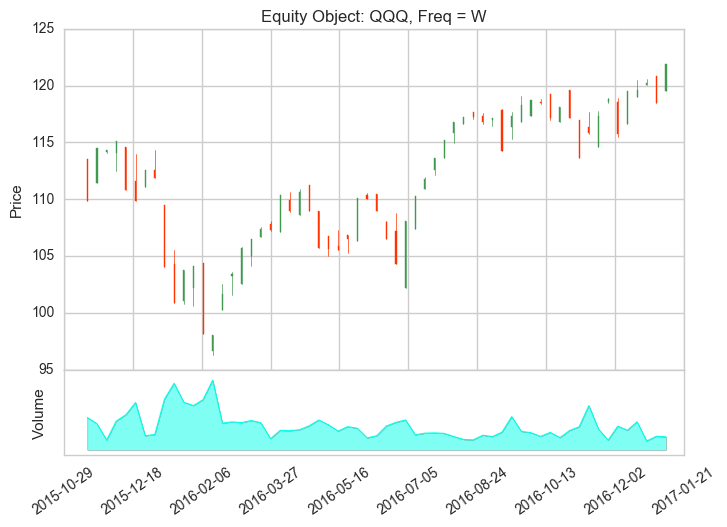

In [15]:
QQQ = data.equities.ETFs['QQQ']
candlestick_chart(QQQ,start=-62, freq='W')

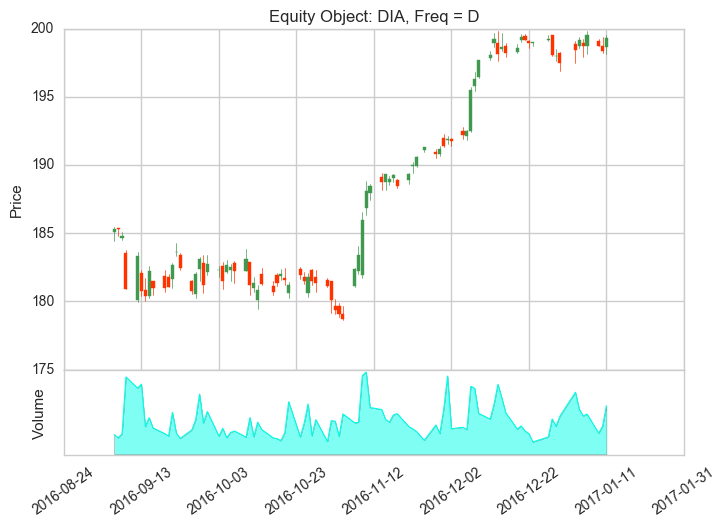

In [16]:
DIA = data.equities.ETFs['DIA']
candlestick_chart(DIA,start=-90, freq='D')

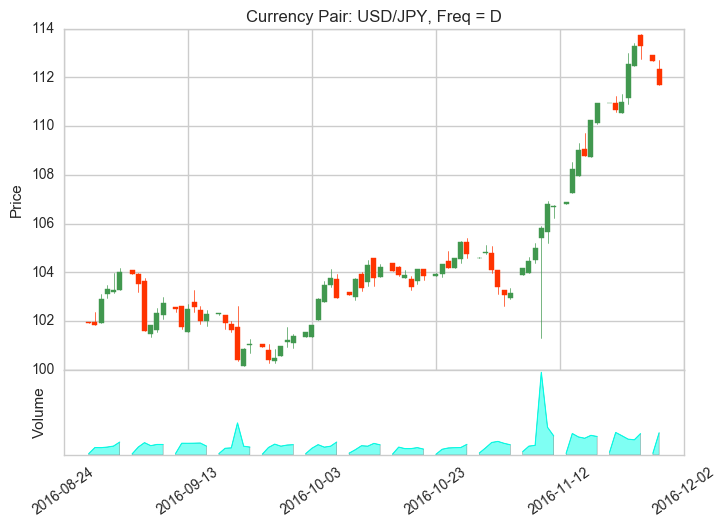

In [17]:
usd_jpy = data.currencies.JPY.USD
candlestick_chart(usd_jpy,start=-95, freq='D')

# The Data:
I created a data pipeline which pullded data from various sources, adjusts it (splits, dividends..), and cleans it.

### Equities:
 - Roughly **6500** US listed **stocks**
  - NASDAQ and NYSE
  - source: **Yahoo! Finance**
  - All available as of **Jan 1, 2017**
  - Beginning date - **Jan 1, 1990**
  - **Daily** data
      - resampled for higher time frames
 - Used Market Index **ETF**s (Exchange Traded Funds) as benchmarks
  - Primarilly **SPY** - S&P 500 market index fund

# The Data:
### Currencies
 - Pulled from Oanda, provider of foreign exchange services
 - **28 Pairs**:
  - EUR/USD, GBP/USD, AUD/USD, NZD/USD, EUR/GBP, EUR/CAD, USD/CAD, GBP/CAD, AUD/CAD, NZD/CAD, EUR/AUD, GBP/AUD, EUR/JPY, USD/JPY, GBP/JPY, CAD/JPY, AUD/JPY, CHF/JPY, NZD/JPY, EUR/CHF, USD/CHF, GBP/CHF, CAD/CHF, AUD/CHF, NZD/CHF, EUR/NZD, GBP/NZD, AUD/NZD
 - Hourly data from Jan 1, **2002** to Jan 1, **2017**

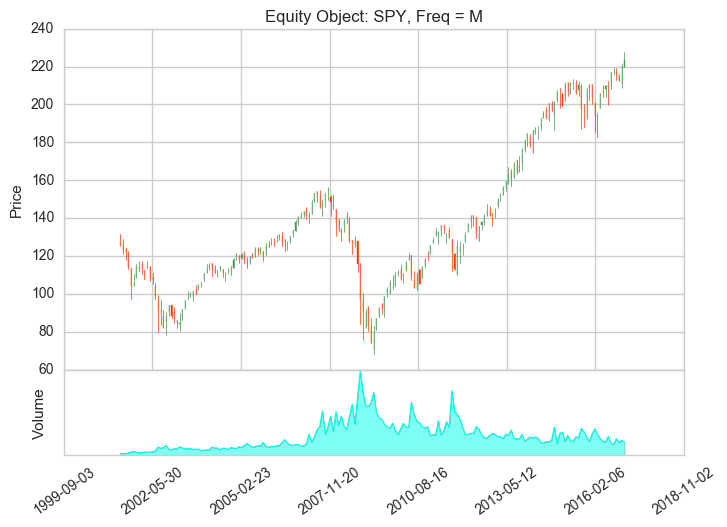

In [18]:
candlestick_chart(data.equities.ETFs['SPY'],start = 100, freq='M')

# The Normal Distribution:
A probability density function for a continuous random variable, defined by mean $\mu$ and standard deviation $\sigma$ as:
$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(x - \mu)^{2}}{2 \sigma^{2}}} $$

# The Normal Distribution:
![Normal_Distribution](pres_pics/normal.png)

# Skewness

Describes the symmetry of the distribution.
 - longer tails
 - negatively skewed, positively skewed
 - Normal Distribution has 0 skewness
calculated as:
$$S_K = \frac{n}{(n-1)(n-2)} \sum_{i=1}^n\left(\frac{(X_i - \overline{X})}{\sigma}\right)^{3}$$
for sample mean $\overline{X}$, and $n$ samples.

# Skewness
![Skewness_Example](pres_pics/skewness.png)

# Kurtosis

Measures the shape of the distribution from the mean
 - how the center and tails act
 - Normal distribution has a kurtosis of 3
  - kurtosis usually measured as excess kurtosis of 3
  
$$K = \frac{1}{n}\frac{\sum_{i=1}^{n}(X-\overline{X})^{4})}{s^{4}}$$

 - **Leptokurtic** - $K > 3$
 - **Mesokurtic** - $K = 3$
 - **Platykurtic** - $K < 3$

# Kurtosis
![Kurtosis_Example](pres_pics/kurtosis.png)

# SPY Daily Returns
Normalized histogram of SPY Returns
![normal_SPY](pres_pics/normalSPY.png)

# SPY Daily Returns

**Kurtosis**:
 - $K \approx 10.1 > 3$
  - 10.3 seems relatively high, this should be quantified!

# Goodness of Fit

#### There are a few different ways to test for normality

## Skewness Test
Produce a $Z$-score using the skewness of the distribution, and then test for significance with a cutoff of $p=0.05$
 - Daily Returns of SPY: $Z \approx -3.74611$, $p\approx 0.00018<0.05$
 - Notice, the negative test statistic resulting from a negative skewness value, i.e., a long negative tail.
 

We can visualize this result:

![skewSPY](pres_pics/skew_test_SPY.png)

## Skewness Test

Daily Returns of a randomly selected stock, **FATE**: $Z \approx 13.05$, $p\approx 6.33\cdot 10^{-39}<0.05$

![skewSPY](pres_pics/skew_test_FATE.png)

# Goodness of Fit


## Kurtosis Test
Produce a $Z$-score using the kurtosis of the distribution, and then test for significance with a cutoff of $p=0.05$
 - Daily Returns of SPY: $Z \approx 12.36$,  $p\approx 4.26\cdot 10^{-35}<0.05$


![skewSPY](pres_pics/kurt_test_SPY.png)

# Jarque-Bera Test

The Jarque-Bera test tests for normality by using both the **skewness and the excess kurtosis**. It uses a $JB$ statistc which is calculated as:

$$JB={\frac  {n-k+1}{6}}\left(S^{2}+{\frac  14}(C-3)^{2}\right)$$

where $S$ is the sample skewness, $C$ is the sample kurtosis, and $k$ is the number of regressors. The $JB$ asymptotically has a $\chi^2$ distribution with 2 degrees of freedom.


### SPY JB test

We test for normality of the log returns of SPY
 - null hypothesis: the distribution of returns is normal.
 - significance level of  $p=0.05$
 - Result: $JB\approx 25644.04$ and $p\approx 4.26573\cdot10^{-35}<0.05$
     - we reject the null hypothesis, accept the alternative hypothesis that the returns are not normally distributed. 

## Visualization of JB test result for SPY daily returns
![jb_test_SPY](pres_pics/jb_test_SPY.png)

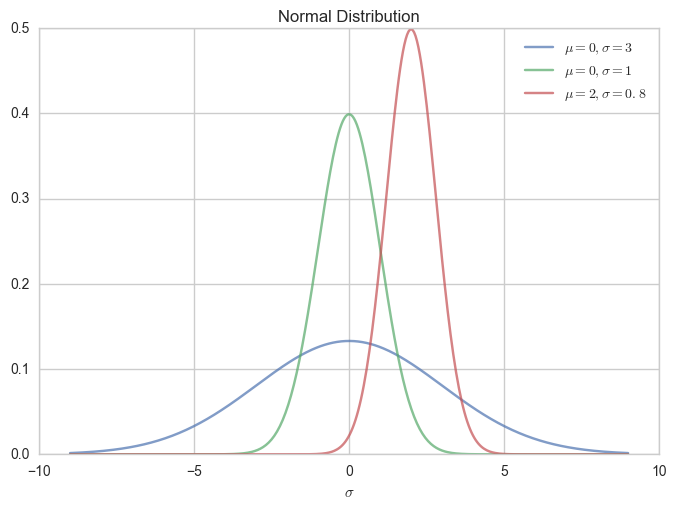

In [93]:
# style.use('seaborn-notebook') # change the look of the plot, more appealing

# A normal distribution with a mean = 0 and std_dev = 3
x = np.linspace(-9,9,400)
normal_3 = stats.norm.pdf(x, loc=0, scale=3)

# A normal distribution with a mean = 0 and std_dev = 1
normal_1 = stats.norm.pdf(x, loc=0, scale=1)

# A normal distribution with a mean = 2 and std_dev = 0.5
normal_2 = stats.norm.pdf(x, loc=2, scale=0.8)

plt.plot(x, normal_3, alpha=0.7)
plt.plot(x, normal_1, alpha=0.7)
plt.plot(x, normal_2, alpha=0.7)
plt.xlabel('$\sigma$')
plt.legend(['$\mu=0, \sigma=3$','$\mu=0, \sigma=1$','$\mu=2, \sigma=0.8$']);
plt.title('Normal Distribution');

## Back to the Analysis

Now that I have easy access to a lot of data, I will resume the analysis of market returns. At the end of Part 1 I left of on the Jarque-Bera test with a couple examples. Now that I have a more efficient Data object to work with, I will many tests for many assets.

In [9]:
def jarque_bera_equities(data, n=60, cutoff=0.05, seed=False, freq='D'):
    """
    Performs Jarque-Bera test on the returns of n equities.
    
    Selects n random equities from data and performs JB test.
    Features a Bonferroni Correction
    Returns number of rejections, rejection percent, scores, p-values.
    """
    if seed:
        np.random.seed(seed)
    num_rejections = 0
    scores = np.zeros(n)
    p_values = np.ones(n)
    assets = data.equities.random_selection(size=n)
    for i in range(len(assets)):
        if freq == 'D':
            scores[i], p_values[i] = stats.jarque_bera(assets[i].returns)
        else:
            resampled_returns = np.log(1 + assets[i].pricing['Adj Close'].resample(freq).last().pct_change())[1:]
            scores[i], p_values[i] = stats.jarque_bera(resampled_returns)
        if p_values[i] <= cutoff/n:
            num_rejections += 1
    rejection_pct = 100 * float(num_rejections) / float(n)
    
    return num_rejections, rejection_pct, scores, p_values

In [12]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_equities(data, n=50)

In [13]:
print('percentage of rejections: ',rejection_pct)

percentage of rejections:  100.0


# Jarque-Bera Test

## Running the JB-Test across a random selection of $n$ equities

**Randomly** select **150** equities, test for normallity of the **daily returns**, significance level $p = 0.05$

 - But of course a correction is in order due to **multiple comparisons**
 - With the **Bonferroni correction**, the new adjusted $p$-value is $p = 0.05/150$
  - With **multiple comparisons** we are likely to see significant results only **due to chance**.
  - We don't want to fool ourselves!

**Results:**
 - $97.\overline{33}\%$ rate of rejection of the null hypothesis (normally distributed) for the 150 equities

# Jarque-Bera Test

### Equities:
We can run a similar test for the **monthly returns** of **50** randomly selected equities.
 - with **Bonferroni Correction**, $p = 0.05/50$
 - **yields a $64\%$ rejection rate**
 

### Currencies:
The same test for the **Hourly, Daily, and Weekly** returns of **28** the currency pairs in the study.
 - with **Bonferroni Correction**, $p = 0.05/28$
 - both time frames **yield a $100\%$ rejection rate**
 

The same test for the **Monthly** returns of **28** the currency pairs in the study.
 - with **Bonferroni Correction**, $p = 0.05/28$
 - **yields a $71.43\%$ rejection rate**

# JB Test Results

The JB test results suggest that equity and currency market returns are **not normally distributed**. 
 - As the sample **time frame** for the returns get **longer**, e.g., days, to weeks, to months, the returns seem to be **less extreme**
  - but still relatively fat tailed compared to the normal distribution.

### If the Normal Distribution is not representative of market returns, what is?
#### Does such a parametric distribution exist?

We can run the same test for Monthly returns.

In [35]:
# Monthly returns
num_rejections, rejection_pct, scores, p_values = jarque_bera_equities(data, n=50, seed=6, freq='M')

In [36]:
print('percentage of rejections for monthly equity returns: ',rejection_pct)

percentage of rejections for monthly equity returns:  64.0


In [16]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_equities(data, n=150, freq='D')
print('percentage of rejections: ',rejection_pct)

percentage of rejections:  97.33333333333333


In [17]:
num_rejections

146

Out of the 150 tested equities, 149 of them failed the Jarque-Bera test. Let's take a look at currencies.

In [23]:
def jarque_bera_currencies(data, cutoff=0.05, seed=False, freq='H'):
    """
    Performs Jarque-Bera test on the returns of n equities.
    
    Selects n random equities from data and performs JB test.
    Features a Bonferroni Correction to combat multiple comparisons bias
    Returns number of rejections, rejection percent, scores, p-values.
    """
    num_currencies = 0 # should later be implemented as data member of data.currencies object
    for base in data.currencies:
        for pair in base:
            num_currencies += 1
    
    if seed:
        np.random.seed(seed)
    num_rejections = 0
    scores = []
    p_values = []
    for base in data.currencies:
        for pair in base:
            if freq == 'H':
                results = stats.jarque_bera(pair.returns)
            else:
                resampled_returns = np.log(1 + pair.pricing['closeAsk'].resample(freq).last().pct_change())[1:]
                results = stats.jarque_bera(resampled_returns)
            scores.append(results[0])
            p_values.append(results[1])
            if results[1] <= cutoff/num_currencies:
                num_rejections += 1
    rejection_pct = 100 * float(num_rejections) / float(len(scores))
    
    return num_rejections, rejection_pct, scores, p_values

In [24]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_currencies(data)
print('percentage of rejections: ',rejection_pct)
print('number of rejections: ',num_rejections)

percentage of rejections:  100.0
number of rejections:  28


In [25]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_currencies(data, freq='W')
print('Weekly currency returns')
print('percentage of rejections: ',rejection_pct)
print('number of rejections: ',num_rejections)

Weekly currency returns
percentage of rejections:  100.0
number of rejections:  28


In [26]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_currencies(data, freq='M')
print('Monthly currency returns')
print('percentage of rejections: ',rejection_pct)
print('number of rejections: ',num_rejections)

Monthly currency returns
percentage of rejections:  71.42857142857143
number of rejections:  20


## Jarque-Bera Conclusions

From the Jarque-Bera test results it seems clear that equity and currency market returns are not normally distributed. As the sample time frame for the returns get longer (days, to weeks, to months), the returns seem to be less extreme or fat tailed, but still fat tailed. The next question is whether we can model them with something else, say another type of distribution, or maybe it isn't even safe to model returns in this way.

## A Visual Comparison

So far I have only used histograms and statistical test to show that markets are non-normal. Histograms, however, make it hard to view the discrepancies between a normal distribution and empirical data. For this, there is a better option.

### Q-Q Plots

The Q-Q plot, or [quantile-quantile plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) plot the quantiles of two distributions against one another. In my case one of the distributions is observed data. If the two distributions are a close match, they will have a linear relationsip between quantiles and therefor show up as a straight line on the plot. From a Q-Q plot it is easy to see the differences in shape of the distributions. If the sample distribution is leptokurtic, then plotted against the normal distribution it will curve down going left and curve up going right, showing a greater frequency of extreme events.

References:

 1. [Quantile-Quantile Plots, Jones](http://people.reed.edu/~jones/Courses/P14.pdf)
 2. [Kemp, Malcolm H. D. Extreme Events: Robust Portfolio Construction in the Presence of Fat Tails. Hoboken, NJ: Wiley, 2011. Print.](https://www.overdrive.com/media/661986/extreme-events)

There is an ok QQ-plot function in the StatsModels library which I will use. I will note that I have modified the source code for the function so that I can plot multiple lines on the same QQ-plot and with different colors.

I will first show what we would expect to see on the Q-Q plot if a sample was taken from a normally distributed random variable. I will create synthetic data.

In [95]:
def normal_dist_simulated_qq():
    # synthetic normal data
    x = np.random.normal(size=1000)

    # plot Q-Q
    fig, ax1 = plt.subplots()
    sm.qqplot(x, fmt='d', fit=True, line='45', ax=ax1)
    for l in ax1.lines: #[:-1]:
        l.set_alpha(.7)
    plt.title('Normal Random Variable vs. Normal Distribution');

# Quantile-Quantile Plot

The **Q-Q plot**, or **quantile-quantile plot**, plots the quantiles of two distributions against one another. In this case one of the distributions is observed data.
 - If two distributions are a close match, they will have a linear relationsip between quantiles and therefore show up as a **straight line** on the plot
 - A great alternative to the histogram, which makes it hard to view the discrepancies between a normal distribution and empirical data.
 - If the sample distribution is leptokurtic, when plotted against the normal distribution it will curve down on the left and curve up on the right, showing a greater frequency of extreme events

# Q-Q Plot
**Normal Distribution - Straight Line Fit**

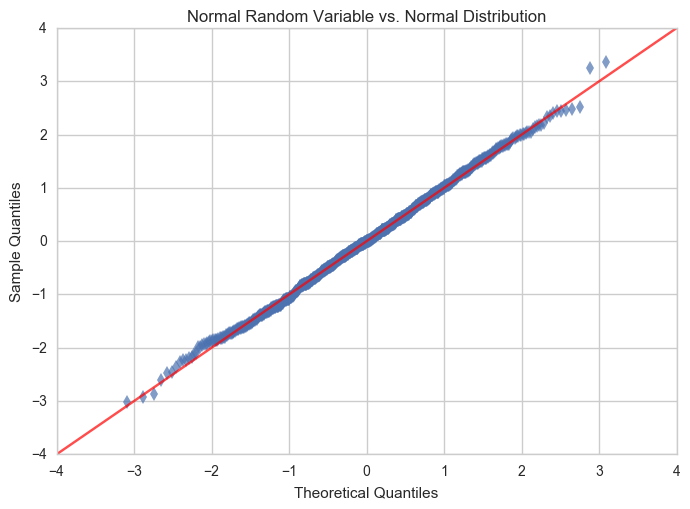

In [96]:
normal_dist_simulated_qq()

Let's then compare this to the Q-Q plot for the SPY returns.

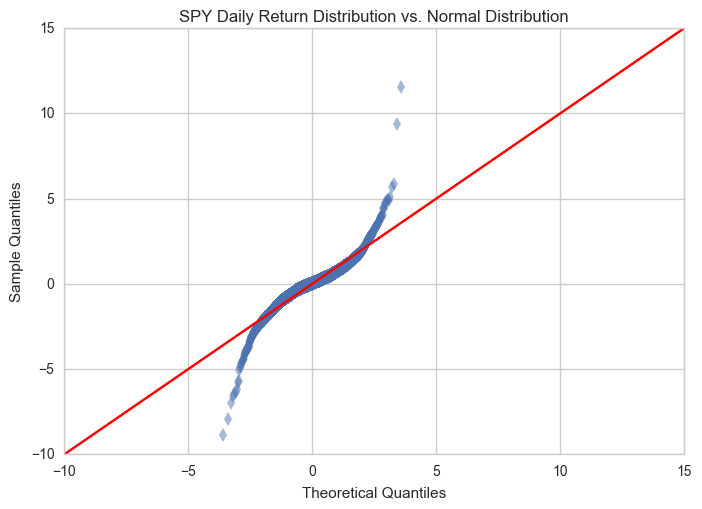

In [99]:
SPY = data.equities.ETFs['SPY']

# plot Q-Q
fig, ax1 = plt.subplots()
sm.qqplot(SPY.returns, fmt='d', fit=True, line='45', ax=ax1)
for l in ax1.lines[:-1]:
    l.set_alpha(.5)
plt.title(SPY.symbol+' Daily Return Distribution vs. Normal Distribution');

This shape is indicative of a fat tail distribution relative to the normal distribution. The distribution for SPY returns shows 8$\sigma$ - 9$\sigma$ data points that corresond to 3$\sigma$ or 4$\sigma$ data points from a normal distribution.

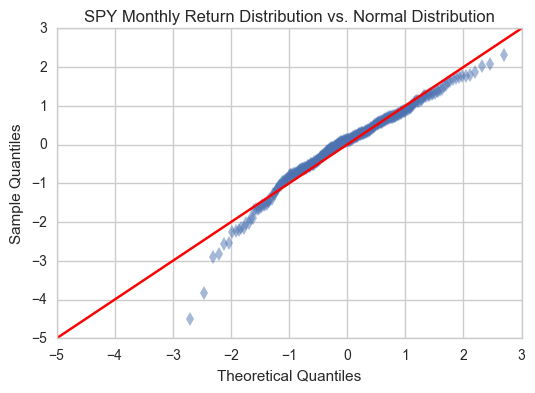

In [102]:
# we sum the daily returns for resampling because log returns
spy_monthly_returns = SPY.returns.resample('M').sum()
# another equivalent way to calculate this from scratch
# spy_weekly_returns_2 = np.log(1 + SPY.pricing['Adj Close'].resample('M').last().pct_change())[1:]

# plot Q-Q
fig, ax1 = plt.subplots()
fig.set_size_inches(6,4)
sm.qqplot(spy_monthly_returns, fmt='d', fit=True, line='45', ax=ax1)
for l in ax1.lines[:-1]:
    l.set_alpha(.5)
plt.title(SPY.symbol+' Monthly Return Distribution vs. Normal Distribution');

In [105]:
def SPY_tf_qq():
    spy_weekly_returns = SPY.returns.resample('W').sum()
    spy_monthly_returns = SPY.returns.resample('M').sum()

    # plot Q-Q
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6,3.5)
    sm.qqplot(spy_weekly_returns, fmt='--', fit=True, line='45', ax=ax1)
    sm.qqplot(spy_monthly_returns, fmt='--', fit=True, ax=ax1)
    sm.qqplot(SPY.returns, fmt='--', fit=True, ax=ax1)
    for i in range(len(ax1.lines)):
        if i != 1:
            ax1.lines[i].set_alpha(.8)
    plt.title(SPY.symbol+' Return Distribution vs. Normal Distribution')
    plt.legend(['Weekly', 'Theoretical', 'Monthly', 'Daily'], loc='best');

# SPY Q-Q Plot

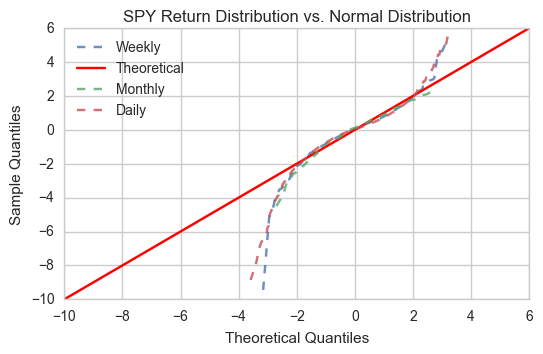

In [106]:
SPY_tf_qq()

 - the dashed red line, daily returns, is indicative of a fat tail distribution
 - the distribution for SPY returns shows 8$\sigma$ - 9$\sigma$ data points that correspond to 3$\sigma$ or 4$\sigma$ data points from a normal distribution
 - positive fat tail somewhat disappears as we move to a larger time frame.

#### Important Observation
As seen in the QQ-plot for the monthly log returns of SPY, it looks like the positive fat tail disappears as we move to a larger timeframe. Let's see if this is true in general for equities and their market index ETFs.

In [107]:
# FOR ETFs on different timeframe
def etf_qq(freq='D', x_min=-10, x_max=10, y_min=-10, y_max=10):
    fig, ax2 = plt.subplots()
    fig.set_size_inches(6,3.5)
    for i in range(len(data.equities.ETFs)):
        if freq != 'D':
            etf_pricing = list(data.equities.ETFs.values())[i].pricing['Adj Close'].resample(freq).last()
            etf_returns = np.log(1 + etf_pricing.pct_change()[1:])
        else:
            etf_returns = list(data.equities.ETFs.values())[i].returns
        if i == 1:
            sm.qqplot(etf_returns, fmt='--', fit=True, line=None, ax=ax2)
        else:
            sm.qqplot(etf_returns, fmt='--', fit=True, ax=ax2)
    for i in range(len(ax2.lines)):
        if i != 1:
            ax2.lines[i].set_alpha(.7)
    ax2.set_xlim([x_min,x_max])
    ax2.set_ylim([y_min,y_max])
    ax2.plot([-10,0,10],[-10,0,10],'r-', alpha=0.5)
    plt.legend(list(data.equities.ETFs.keys())+['Normal Line'], loc='best')
    plt.title('ETFs Return Distribution vs. Normal Distribution, freq = '+freq);

## Market ETF Q-Q Plots
Watch the Transformation!

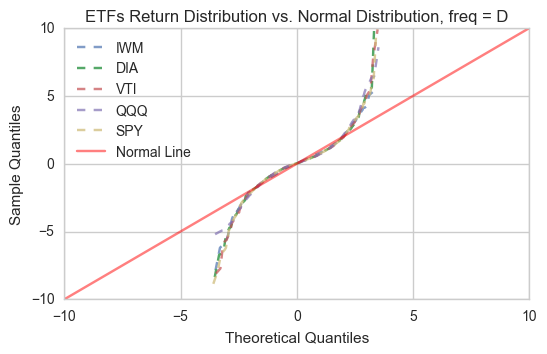

In [108]:
etf_qq(freq='D')

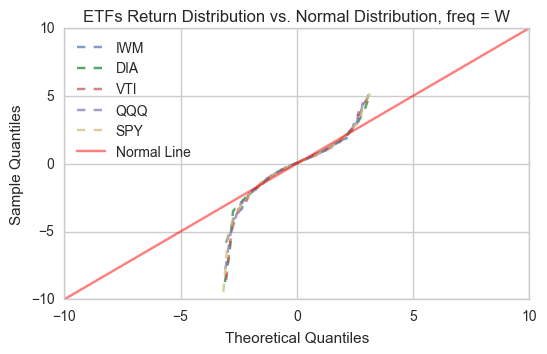

In [109]:
# Weekly returns
etf_qq(freq='W')

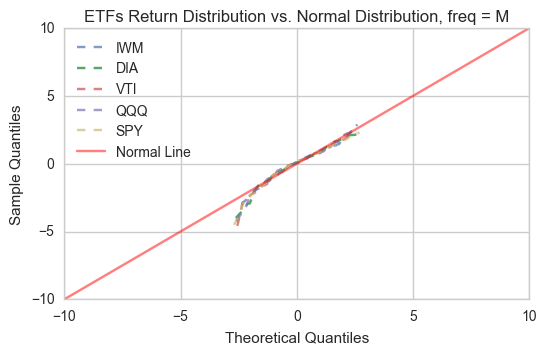

In [110]:
# monthly returns
etf_qq(freq='M')

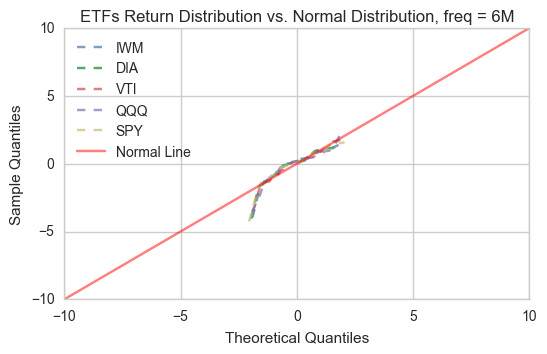

In [111]:
# semi-annual returns (6 months)
etf_qq(freq='6M')

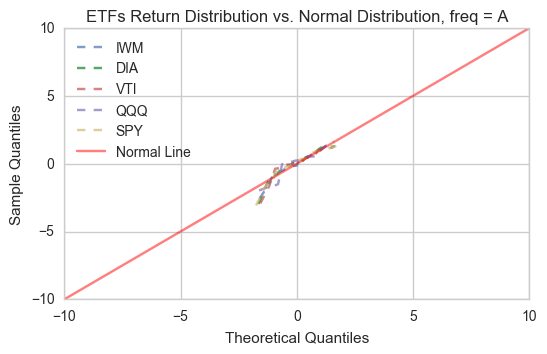

In [112]:
# Yearly returns
etf_qq(freq='A')

At the larger time frames the returns appear to be negatively skewed. Let's confirm this thought. I will write some general functions that create plots of a few statistical moments across various time frames.

In [131]:
def moments_vals(asset_class='ETF', moment='skew', freq='B'):
    scores = {}
    if asset_class == 'ETF':
        for i in range(len(data.equities.ETFs)):
            if freq != 'B':
                etf_pricing = list(data.equities.ETFs.values())[i].pricing['Adj Close'].resample(freq).last()
                etf_returns = np.log(1 + etf_pricing.pct_change()[1:])
            else:
                etf_returns = list(data.equities.ETFs.values())[i].returns
            if moment == 'skew':
                scores[list(data.equities.ETFs.keys())[i]] = stats.skew(etf_returns)
            elif moment == 'kurtosis':
                scores[list(data.equities.ETFs.keys())[i]] = stats.kurtosis(etf_returns)
            elif moment == 'mean':
                scores[list(data.equities.ETFs.keys())[i]] = np.mean(etf_returns)
            elif moment == 'std' or moment == 'starndard deviation':
                scores[list(data.equities.ETFs.keys())[i]] = np.std(etf_returns)
            else:
                raise ValueError('Invalid value for moment')
    elif asset_class == 'currency':
        for base in data.currencies:
            for pair in base:
                if freq != 'H':
                    pricing = pair.pricing['closeAsk'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = pair.returns    
                returns = returns.dropna()
                if moment == 'skew':
                    scores[pair.pair_name] = stats.skew(returns)
                elif moment == 'kurtosis':
                    scores[pair.pair_name] = stats.kurtosis(returns)
                elif moment == 'mean':
                    scores[pair.pair_name] = np.mean(returns)
                elif moment == 'std' or moment == 'starndard deviation':
                    scores[pair.pair_name] = np.std(returns)
                else:
                    raise ValueError('Invalid value for moment')
    else:
        assets = data.equities.random_selection(size=35)
        for i in range(len(assets)):
            if freq == 'B':
                returns = assets[i].returns
            else:
                returns = np.log(1 + assets[i].pricing['Adj Close'].resample(freq).last().pct_change())[1:]
            
            if moment == 'skew':
                scores[assets[i].symbol] = stats.skew(returns)
            elif moment == 'kurtosis':
                scores[assets[i].symbol] = stats.kurtosis(returns)
            elif moment == 'mean':
                scores[assets[i].symbol] = np.mean(returns)
            elif moment == 'std' or moment == 'starndard deviation':
                scores[assets[i].symbol] = np.std(returns)
            else:
                raise ValueError('Invalid value for moment')
            
    return scores

def timeframe_moments_plot(asset_class='ETF', moment='skew'):
    if asset_class == 'currency':
        H = moments_vals(asset_class, freq='H')
    B = moments_vals(asset_class, moment=moment, freq='B')
    W = moments_vals(asset_class, moment=moment, freq='W')
    M = moments_vals(asset_class, moment=moment, freq='M')
    M3 = moments_vals(asset_class, moment=moment, freq='3M')
    M6 = moments_vals(asset_class, moment=moment, freq='6M')
    A = moments_vals(asset_class, moment=moment, freq='A')
    
    if asset_class == 'currency':
        tfs = [H,B,W,M,M3,M6,A]
    else:
        tfs = [B,W,M,M3,M6,A]
    scores = {}
    
    for i in range(len(B)):
        asset = list(B.keys())[i]
        scores[asset] = [tf[asset] for tf in tfs]
    
    df = DataFrame.from_dict(scores)
    if asset_class == 'currency':
        df.index = ['H','B','W','M','3M','6M','A']
    else:
        df.index = ['B','W','M','3M','6M','A']
    
    df.plot(figsize=(6,3.5))

    if asset_class != 'currency':
        plt.legend()
    else:
        ax = plt.gca()
        ax.legend().set_visible(False)
        
    plt.xlabel('Time Frame')
    plt.ylabel(moment)
    plt.title(asset_class+' Return '+moment+' of Different Time Frames');
    

# Skewness of the ETFs
From the previous plots, it looks like the positive fat tail begins to disappear at the large time frames. This would make the resulting distributiong have a single negative fat tail, or negative skewness.

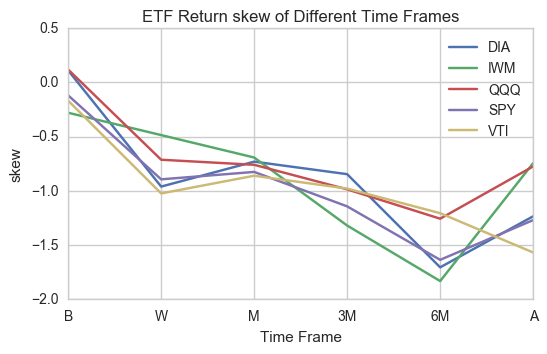

In [132]:
timeframe_moments_plot(asset_class='ETF', moment='skew')

- For buy and hold investors, this is important to note.

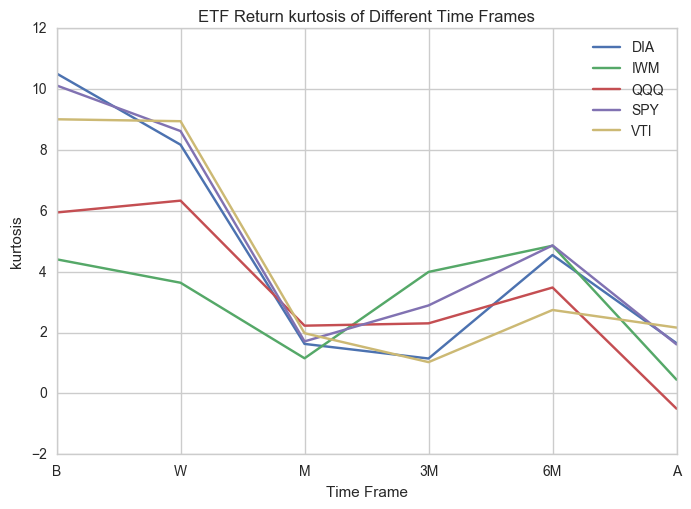

In [150]:
timeframe_moments_plot(asset_class='ETF', moment='kurtosis')

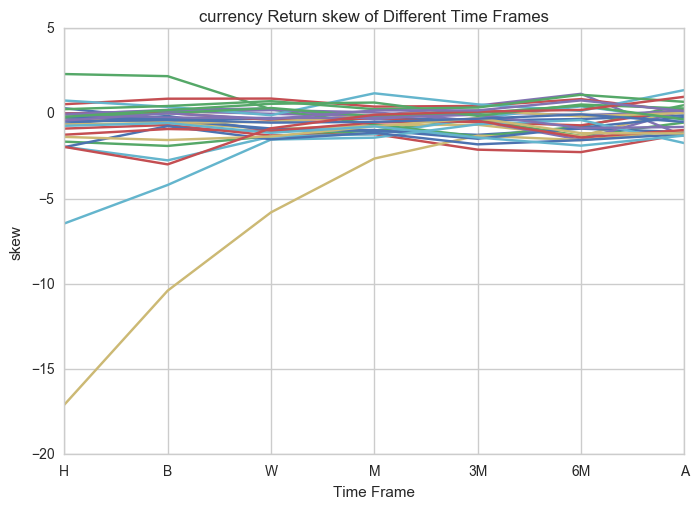

In [147]:
timeframe_moments_plot(asset_class='currency')

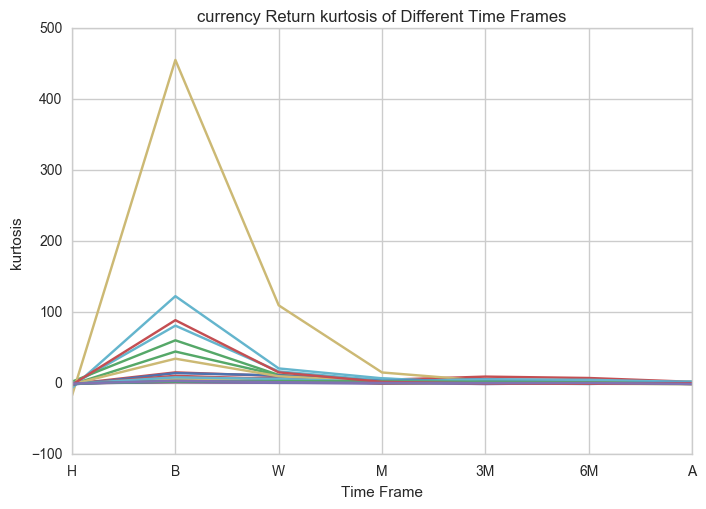

In [153]:
timeframe_moments_plot(asset_class='currency', moment='kurtosis')

In [113]:
# FOR assets on different timeframe
def data_qq(asset_class='ETF', dist=stats.norm, freq='D', fit=True, alpha=0.7, x_min=-10, x_max=10, y_min=-10, y_max=10):
    fig, ax2 = plt.subplots()
    fig.set_size_inches(6,3.5)
    
    counter = 0
    if asset_class == 'currency':
        for base in data.currencies:
            for pair in base:
                counter += 1
                if freq != 'H':
                    pricing = pair.pricing['closeAsk'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = pair.returns    
                returns = returns.dropna()
                if counter == 1:
                    sm.qqplot(returns, dist=dist, fmt='--', fit=fit, line=None, ax=ax2)
                else:
                    sm.qqplot(returns, dist=dist, fmt='--', fit=fit, ax=ax2)
    else:
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            assets = data.equities.random_selection(size=35)
        for asset in assets:
            counter += 1
            if freq != 'D':
                pricing = asset.pricing['Adj Close'].resample(freq).last()
                returns = np.log(1 + pricing.pct_change()[1:])
            else:
                returns = asset.returns
            if counter == 1:
                sm.qqplot(returns, dist=dist, fmt='--', fit=fit, line=None, ax=ax2)
            else:
                sm.qqplot(returns, dist=dist, fmt='--', fit=fit, ax=ax2)

    
    for i in range(len(ax2.lines)):
            if i != 1:
                ax2.lines[i].set_alpha(alpha)
                
    ax2.set_xlim([x_min,x_max])
    ax2.set_ylim([y_min,y_max])
    ax2.plot([-10,0,10],[-10,0,10],'r-', alpha=0.65)
    plt.title(asset_class+' Return Distribution vs. '+dist.name+' Distribution, freq = '+freq);

# Currency Returns Q-Q Plots
Watch the transformation!

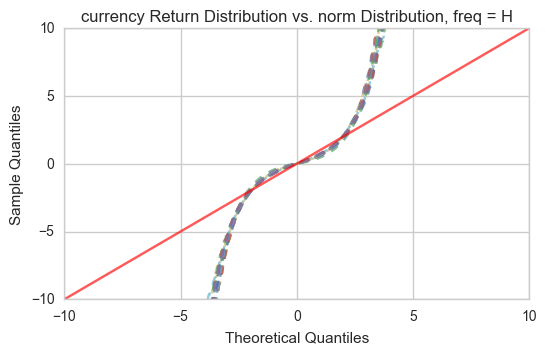

In [114]:
data_qq(asset_class='currency', freq='H')

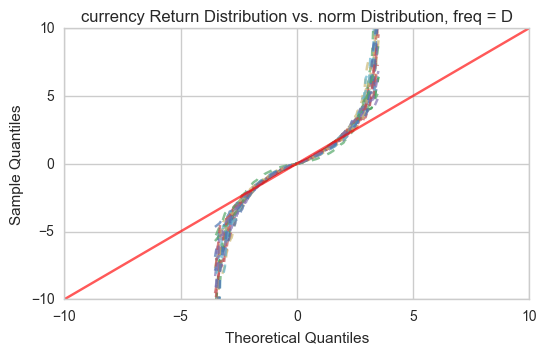

In [115]:
data_qq(asset_class='currency', freq='D')

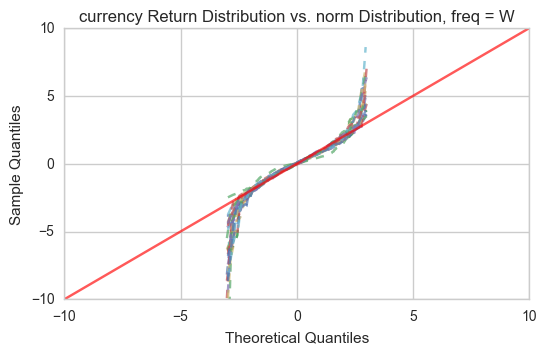

In [116]:
data_qq(asset_class='currency', freq='W')

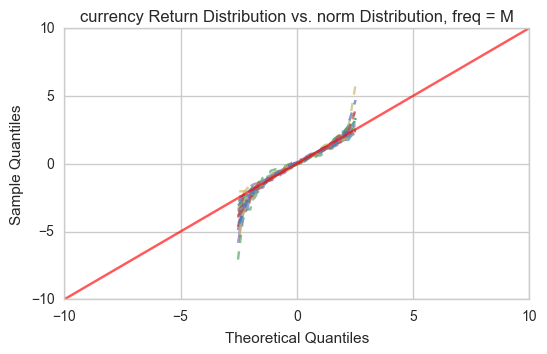

In [117]:
data_qq(asset_class='currency', freq='M')

# Equity Returns Q-Q Plots
Watch the trasformation!

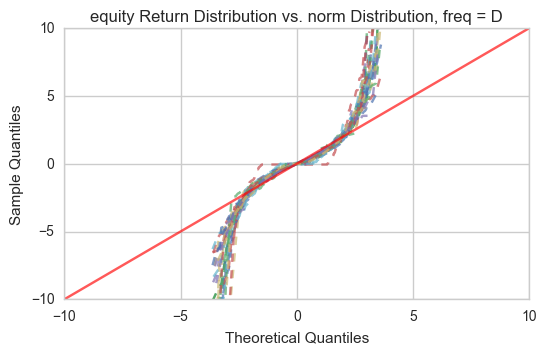

In [118]:
data_qq(asset_class='equity', freq='D')

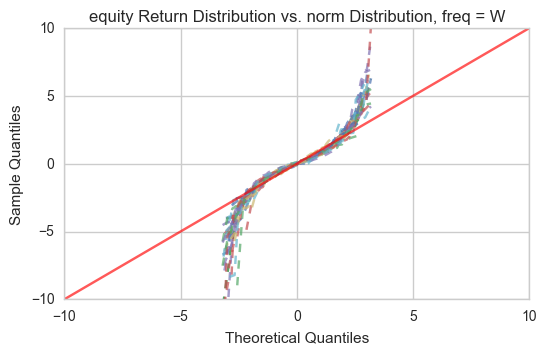

In [133]:
data_qq(asset_class='equity', freq='W')

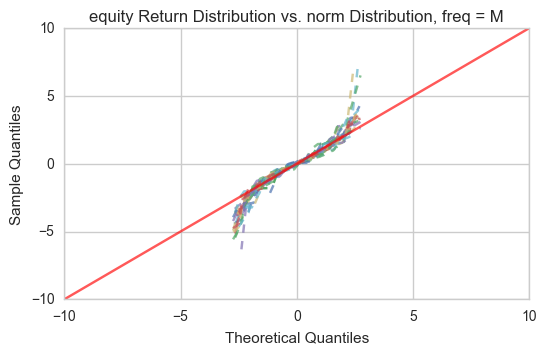

In [134]:
data_qq(asset_class='equity', freq='M')

In [139]:
def cross_tf_qq(asset_class='ETF', dist=stats.norm, fit=True, alpha=0.2, x_min=-8, x_max=8, y_min=-8, y_max=8):
    
    fig, ax2 = plt.subplots()
    fig.set_size_inches(6,3.5)
    counter = 0
    if asset_class == 'currency':
        tfs = {'H':'r','D':'b','W':'c','M':'y','6M':'g','A':'m'}
        for tf, c in tfs.items():
            for base in data.currencies:
                for pair in base:
                    counter += 1
                    if tf != 'H':
                        pricing = pair.pricing['closeAsk'].resample(tf).last()
                        returns = np.log(1 + pricing.pct_change())[1:]
                    else:
                        returns = pair.returns    
                    returns = returns.dropna()
                    if counter == 1:
                        sm.qqplot(returns, dist=dist,fmt=(c+'--'), fit=fit, line='45', ax=ax2)
                    else:
                        sm.qqplot(returns, dist=dist,fmt=(c+'--'), fit=fit, ax=ax2)
    else:
        tfs = {'D':'b','W':'c','M':'y','6M':'g','A':'m'}
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            assets = data.equities.random_selection(size=35)
        for tf, c in tfs.items():
            for asset in assets:
                counter += 1
                if tf != 'D':
                    pricing = asset.pricing['Adj Close'].resample(tf).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = asset.returns
                returns = returns.dropna()
                if counter == 1:
                    sm.qqplot(returns, dist=dist, fmt=(c+'--'), fit=fit, line='45', ax=ax2)
                else:
                    sm.qqplot(returns, dist=dist, fmt=(c+'--'), fit=fit, ax=ax2)
        
    for i in range(len(ax2.lines)):
            if i != 1:
                ax2.lines[i].set_alpha(alpha)
    labels = list(tfs.keys())
    # labels.append('Theoretical Fit Line')
    
    ax2.set_xlim([x_min,x_max])
    ax2.set_ylim([y_min,y_max])
    ax2.plot([-10,0,10],[-10,0,10],'r-', alpha=0.65)
    
    # a hacky way to get the colors right on the legend
    markers = [plt.Line2D([0,0],[0,0],color=color, alpha=0.7, linestyle='--') for color in tfs.values()]#\
#                + [plt.Line2D([0,0],[0,0],color='r', alpha=0.7, linestyle='-')] 
    plt.legend(markers, labels, numpoints=1, loc='best')
    plt.title(asset_class+' Time Frame Comparisons, '+dist.name+' QQ Plot')


# Q-Q Plots Across Time Frames
We can compare all available time frames at once to visualize the fit.
## Currencies

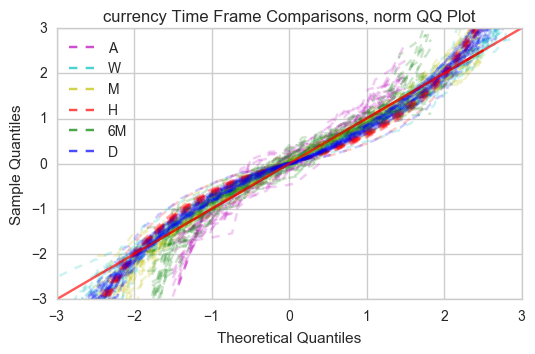

In [127]:
cross_tf_qq(asset_class='currency')

## ETFs

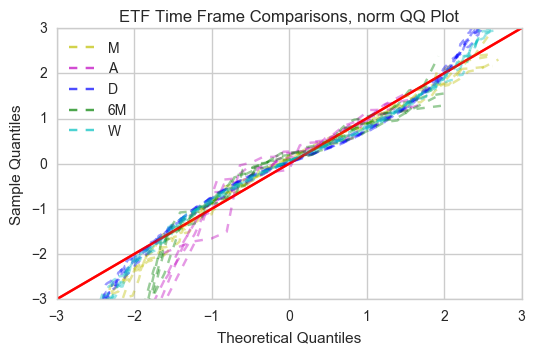

In [128]:
cross_tf_qq(asset_class='ETF',alpha=0.4)

## Equities

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/graphics/gofplots.py:183: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


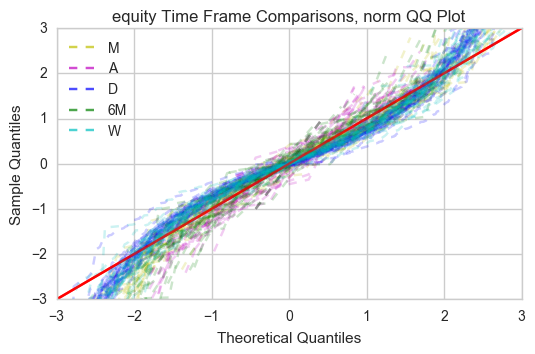

In [129]:
cross_tf_qq(asset_class='equity',alpha=0.2)

# Q-Q Plot insights
 - The distribution for hourly Currency returns shows 15$\sigma$ - 20$\sigma$ data points that correspond to about 4$\sigma$ data points from a normal distribution. 
 - Indicates that the currency market on the hourly time frame frequently exhibits **severe market moves**, far **more than predicted by a normal distribution**.
 - As the time frame increases, positive fat tails shrink more than negative fat tails, which remain.
  - How might this affect traders? Buy and hold investors?

# Finding a Better Fit

We can use the Q-Q Plot with other distributions besides the normal distribution.

## The Laplace Distribution

- essentially a double exponential distribution
- leptokurtic and features power-law decay in the tails, expressed via fat tails
- These characteristics make it a potential fit with market returns.

## Finding a Better Fit

So it seems that the normal distribution is not a great fit. When various assets are plotted on a QQ-plot with a normal distribution, it creates a curve that is indicative of a fat tail distribution. The QQ-plot can also be used with other distributions. In this way, we can use it to see what distribution fits best with the distribution of market returns.

### The Laplace Distribution

The [Laplace Distribution](https://en.wikipedia.org/wiki/Laplace_distribution) is essentially a double exponential distribution. The exposnential distribution features power-law decay in the tails.

In [136]:
def plot_laplace_vs_normal():
    fig = plt.figure(figsize=(6,3.5))
    x = np.linspace(-8,8,150)
    y_l = stats.laplace.pdf(x)
    y_n = stats.norm.pdf(x)
    plt.plot(x,y_l, label='Laplace', alpha=0.7)
    plt.plot(x,y_n, label='Normal', alpha=0.7)
    plt.legend()
    plt.xlabel('$\sigma$')
    plt.title('Probability Density Function');

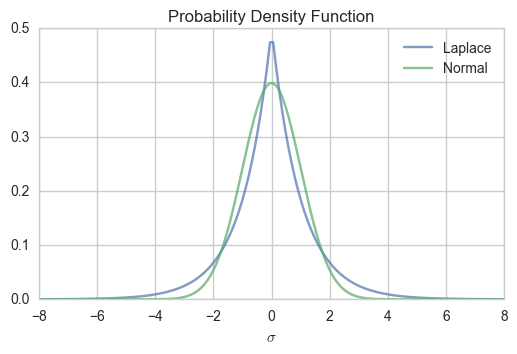

In [137]:
plot_laplace_vs_normal()

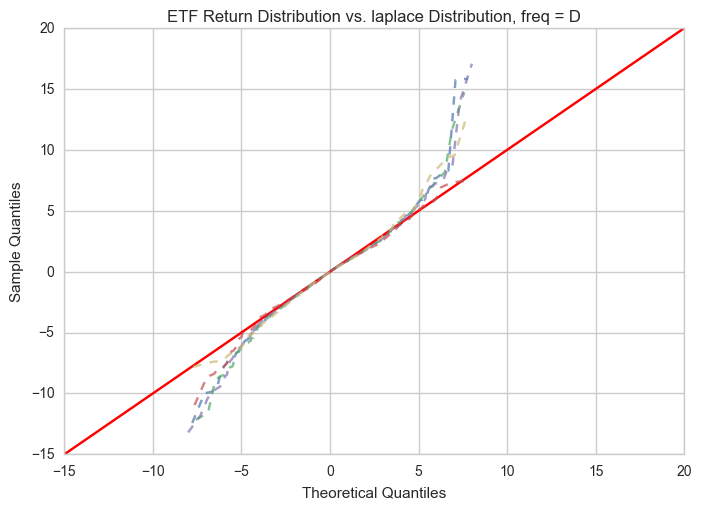

In [242]:
data_qq(asset_class='ETF', dist=stats.laplace, freq='D')

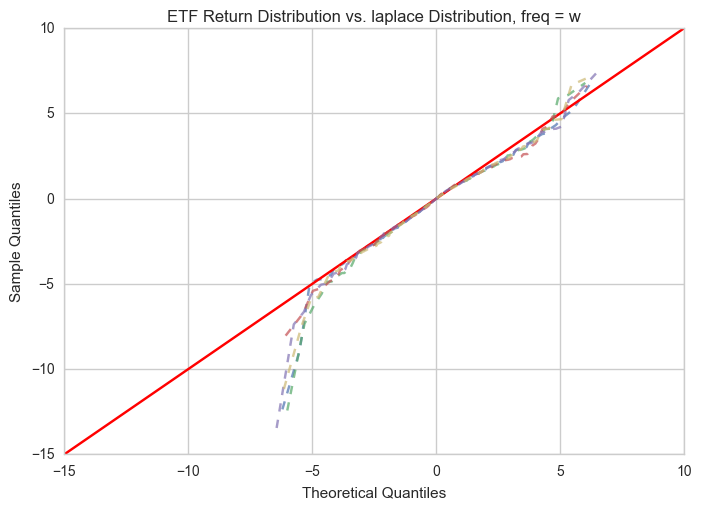

In [243]:
data_qq(asset_class='ETF', dist=stats.laplace, freq='w')

# Laplace Q-Q Plot

## ETFs

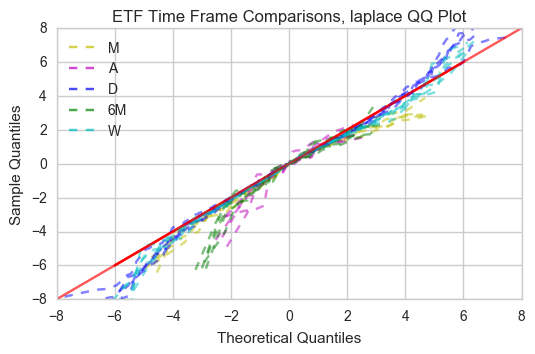

In [141]:
cross_tf_qq(asset_class='ETF', dist=stats.laplace, alpha=0.5)

# Laplace Q-Q Plot

### Currencies


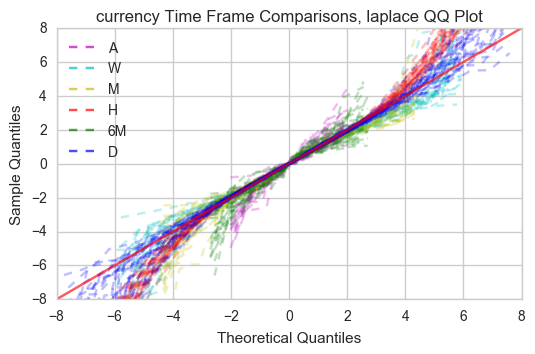

In [142]:
cross_tf_qq(asset_class='currency', dist=stats.laplace, alpha=0.25)

# Laplace Q-Q Plot

## Equities

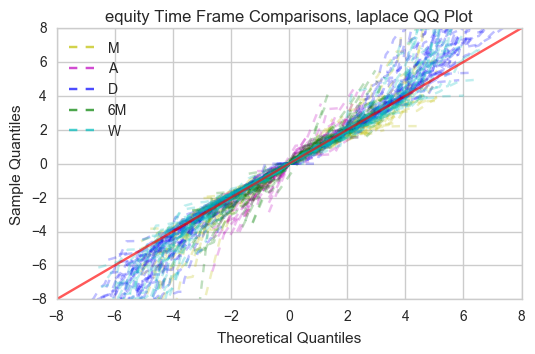

In [143]:
cross_tf_qq(asset_class='equity', dist=stats.laplace, alpha=0.25)

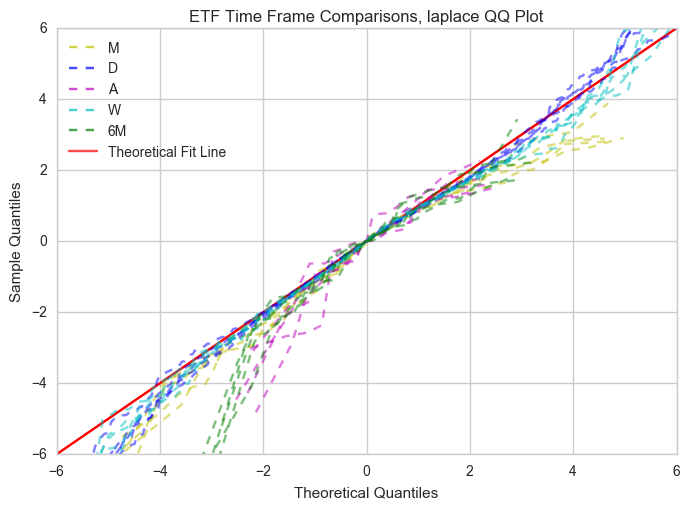

In [15]:
cross_tf_qq(asset_class='ETF', dist=stats.laplace, alpha=0.5)

From the chart above, we can see that the laplace distribution is a relatively good for market ETFs for the day, week, and month time frames as compared to the Normal distribution. Although the fit is better, it is still not perfect. Even though the fit is better, there is a pretty fat negative tail in the market returns compare to that of the Laplace distribution. This is show as the downward sloping lines on the bottom left of the plot, below the theoretical fit line.

### Other Distributions

Here I will write a function to compare market return distributions against multiple theoretical distributions.

#### Distributions:
These are a few standard fatter tailed (leptokurtic) continuious random variable distributions.
 - T-Distribution
 - Cauchy Distribution

In [144]:
def cross_dist_qq(asset_class='ETF', dists_to_compare=[stats.norm, stats.laplace], fit=True, freq='D', alpha=0.2):
    
    fig, ax2 = plt.subplots()
    fig.set_size_inches(6,3.5)
    counter = 0
    colors = ['r','b','c','y','g','m','r','b','c','y','g','m','r','b','c','y','g','m']
    if len(colors) < len(dists_to_compare):
        raise RuntimeError('dists_to_compare is too long, must be less than length of 18')
    colors = colors[:len(dists_to_compare)]
    if asset_class == 'currency':
        for dist, c in zip(dists_to_compare,colors):
            for base in data.currencies:
                for pair in base:
                    counter += 1
                    if freq != 'H':
                        pricing = pair.pricing['closeAsk'].resample(freq).last()
                        returns = np.log(1 + pricing.pct_change())[1:]
                    else:
                        returns = pair.returns    
                    returns = returns.dropna()
                    if counter == 1:
                        sm.ProbPlot(returns, dist=dist, fit=fit, distargs=())
                        sm.qqplot(returns, dist=dist,fmt=(c+'--'), fit=fit, line='45', ax=ax2)
                    else:
                        sm.qqplot(returns, dist=dist,fmt=(c+'--'), fit=fit, ax=ax2)
    else:
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            assets = data.equities.random_selection(size=35)
        for dist, c in zip(dists_to_compare,colors):
            for asset in assets:
                counter += 1
                if freq != 'D':
                    pricing = asset.pricing['Adj Close'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = asset.returns
                returns = returns.dropna()
                if counter == 1:
                    sm.qqplot(returns, dist=dist, fmt=(c+'--'), fit=fit, line='45', ax=ax2)
                else:
                    sm.qqplot(returns, dist=dist, fmt=(c+'--'), fit=fit, ax=ax2)
        
    for i in range(len(ax2.lines)):
            if i != 1:
                ax2.lines[i].set_alpha(alpha)
    labels = [dist.name for dist in dists_to_compare]
    labels.append('Theoretical Fit Line')
    
    # a hacky way to get the colors right on the legend
    markers = [plt.Line2D([0,0],[0,0],color=color, alpha=0.7, linestyle='--') for color in colors]\
                + [plt.Line2D([0,0],[0,0],color='r', alpha=0.7, linestyle='-')] 
    plt.legend(markers, labels, numpoints=1, loc='best')
    plt.title(asset_class+' Distribution Comparison QQ Plot, frequency = '+freq)


# Other Distributions

### T-Distribution
### Cauchy

The Cauchy distribution and the T-distribution are two standard relatively fat tailed (leptokurtic) continuous random variable distributions. We can plot the normal, Laplace, Cauchy, and T distributions all at once against Currency returns to compare their relative fit.

# ETF Q-Q Plot

### Comparing Distributions

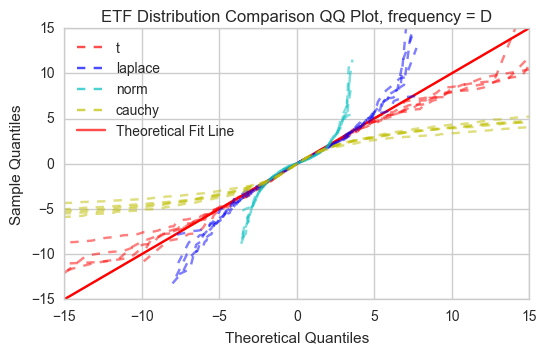

In [145]:

dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='ETF', dists_to_compare=dists, freq='D',alpha=0.5)

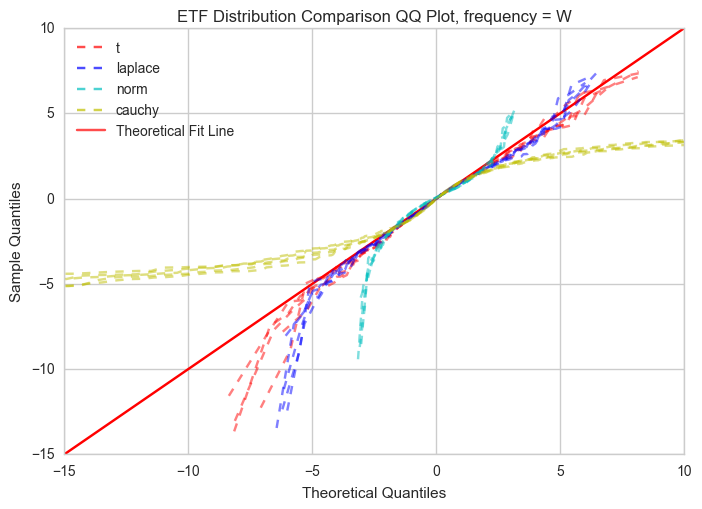

In [58]:

dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='ETF', dists_to_compare=dists, freq='W',alpha=0.5)

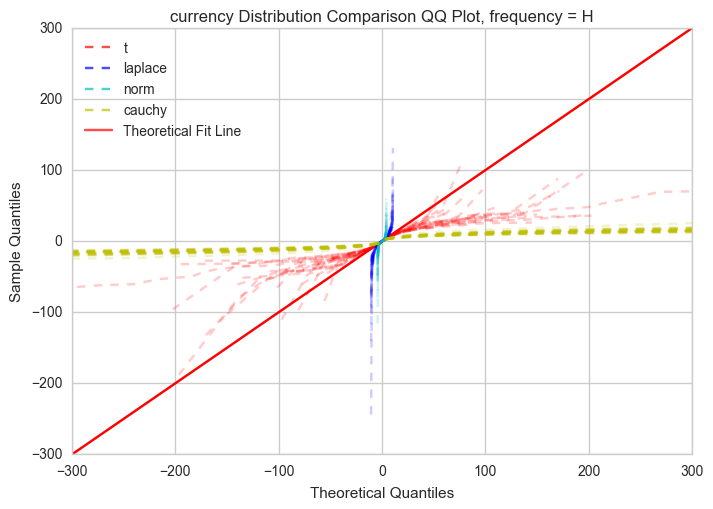

In [21]:
dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='currency', dists_to_compare=dists, freq='H',alpha=0.2)

# Currency Q-Q Plot

### Comparing Distributions, Daily returns

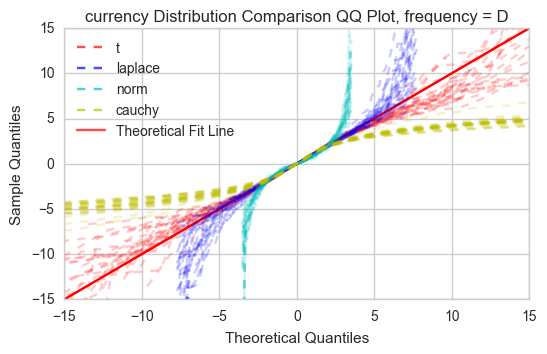

In [146]:
dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='currency', dists_to_compare=dists, freq='D',alpha=0.2)

# Currency Q-Q Plot

### Comparing Distributions, Weekly returns

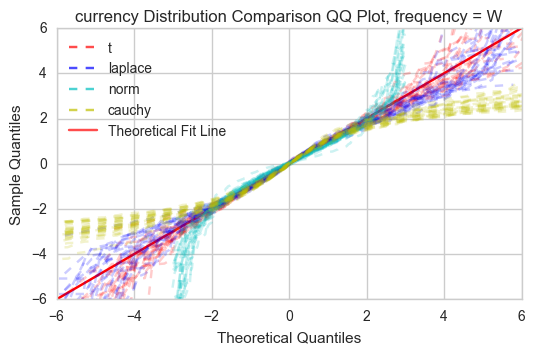

In [147]:
dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='currency', dists_to_compare=dists, freq='W',alpha=0.2)

# Equity Q-Q Plot

### Comparing Distributions, Daily returns

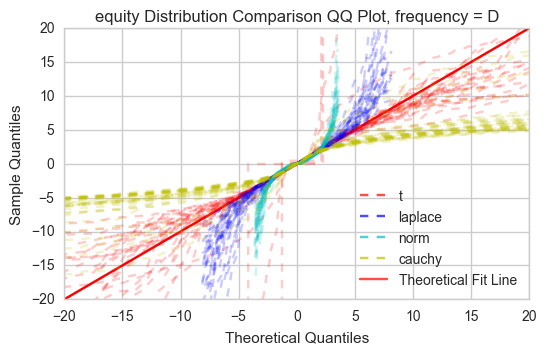

In [148]:
np.random.seed(5144)
dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='equity', dists_to_compare=dists, freq='D',alpha=0.2)

# Equity Q-Q Plot

### Comparing Distributions, Weekly returns

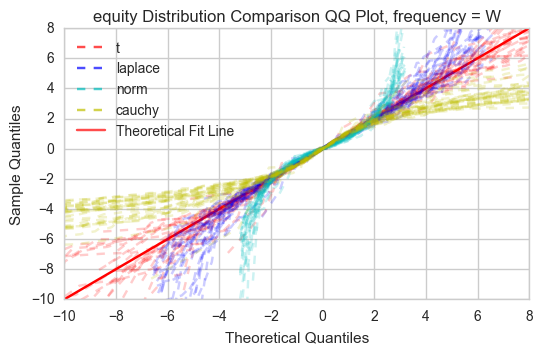

In [149]:
np.random.seed(5144)
dists = [stats.t, stats.laplace, stats.norm, stats.cauchy]
cross_dist_qq(asset_class='equity', dists_to_compare=dists, freq='W',alpha=0.2)

#### T-Distributions

Among those distributions explored, the one which seemed to yield the best fit is the T-Distribution. The function above is fitting the T-Distribution to the data to determine the parameters (including the degrees of freedom) everytime it plots it. This is somewhat overfitting. T-Distributions are defined by their degrees of freedom, location (mean), and scale (standard deviation). It would be better practice to find a single T-Distribution with the same degree of freedom that in general fits with all the data.

In [152]:
def plot_example_t_dists():
    fig = plt.figure(figsize=(6,3.5))
    x = np.linspace(-8,8,150)
    y_n = stats.norm.pdf(x)
    DFs = [1,3, 5,10, 30]
    plt.plot(x,y_n, label='Normal', alpha=0.9)
    for df in DFs:
        plt.plot(x, stats.t.pdf(x,df=df), label='DF = '+str(df), alpha=0.5)
    plt.legend()
    plt.xlabel('$\sigma$')
    plt.title('Probability Density Function, T-Distribution');

# T-Distribution

 - defined by mean, standard deviation, and degree of freedom

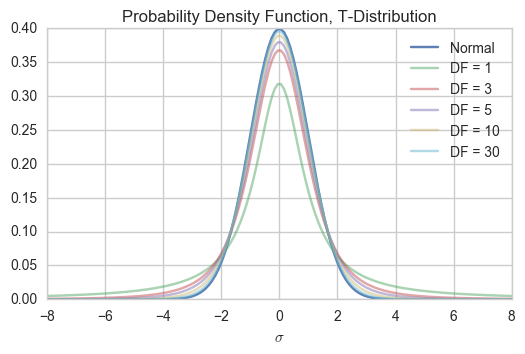

In [153]:
plot_example_t_dists()

 - seemed to be a reasonable if in the Q-Q Plots
 - To avoid over-fitting, find a single T-Distribution with a specific number of degrees of freedom that in general fits the data

In [155]:
def t_dist_qq(asset_class='ETF', DFs=[3, 4, 5, 6,10, 30],
                  fit=False, a=0, loc=0, scale=1, freq='D', alpha=0.2):
    
    fig, ax2 = plt.subplots()
    fig.set_size_inches(6,3.5)
    dist = stats.t
    counter = 0
    colors = ['r','b','c','y','g','m','r','b','c','y','g','m','r','b','c','y','g','m']
    if len(colors) < len(DFs):
        raise RuntimeError('DFs is too long, must be less than length of 18')
    colors = colors[:len(DFs)]
    if asset_class == 'currency':
        for DF, c in zip(DFs,colors):
            for base in data.currencies:
                for pair in base:
                    counter += 1
                    if freq != 'H':
                        pricing = pair.pricing['closeAsk'].resample(freq).last()
                        returns = np.log(1 + pricing.pct_change())[1:]
                    else:
                        returns = pair.returns    
                    returns = returns.dropna()
                    asset_mean = np.mean(returns)
                    asset_std = np.std(returns)
                    if counter == 1:
                        sm.qqplot(returns, dist=dist, distargs=[DF], fit=fit, a=a,
                                  loc=asset_mean, scale=asset_std, fmt=(c+'--'), line='45', ax=ax2)
                    else:
                        sm.qqplot(returns, dist=dist, distargs=[DF], fit=fit, a=a,
                                  loc=asset_mean, scale=asset_std, fmt=(c+'--'), ax=ax2)
    else:
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            assets = data.equities.random_selection(size=35)
        for DF, c in zip(DFs,colors):
            for asset in assets:
                counter += 1
                if freq != 'D':
                    pricing = asset.pricing['Adj Close'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = asset.returns
                returns = returns.dropna()
                asset_mean = np.mean(returns)
                asset_std = np.std(returns)
                if counter == 1:
                    sm.qqplot(returns, dist=dist, distargs=[DF], fit=fit, a=a,
                              loc=asset_mean, scale=asset_std, fmt=(c+'--'), line='45', ax=ax2)
                else:
                    sm.qqplot(returns, dist=dist, distargs=[DF], fit=fit, a=a,
                              loc=asset_mean, scale=asset_std, fmt=(c+'--'), ax=ax2)
        
    for i in range(len(ax2.lines)):
            if i != 1:
                ax2.lines[i].set_alpha(alpha)
    labels = ['DF = '+str(num) for num in DFs]
    labels.append('Theoretical Fit Line')
    
    # a hacky way to get the colors right on the legend
    markers = [plt.Line2D([0,0],[0,0],color=color, alpha=0.7, linestyle='--') for color in colors]\
                + [plt.Line2D([0,0],[0,0],color='r', alpha=0.7, linestyle='-')] 
    plt.legend(markers, labels, numpoints=1, loc='best')
    plt.title(asset_class+' VS T-Dist QQ-Plot with varying DF, freq = '+freq)


# Currency Q-Q Plot

### T-Distributions, varying degrees of freedom, Daily returns

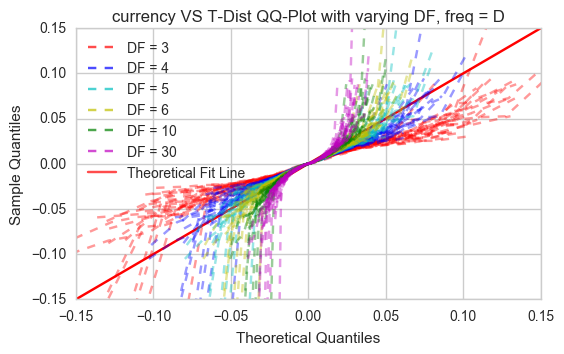

In [156]:
t_dist_qq(asset_class='currency', alpha=0.4)

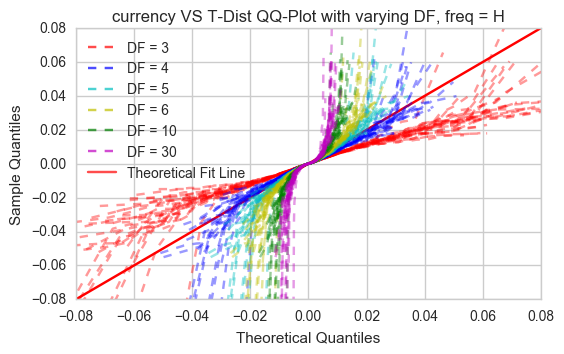

In [157]:
t_dist_qq(asset_class='currency', freq='H', alpha=0.4)

# Currency Q-Q Plot

### T-Distributions, varying degrees of freedom, Weekly returns

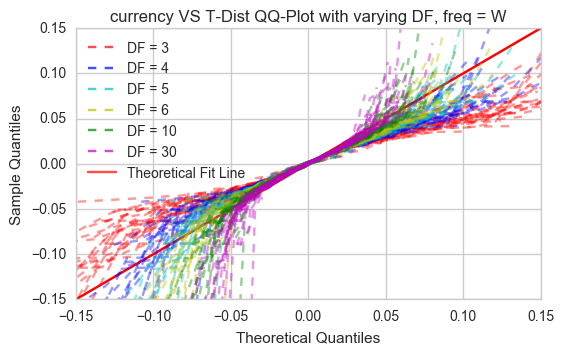

In [158]:
t_dist_qq(asset_class='currency', freq='W', alpha=0.4)

# Currency Q-Q Plot

### T-Distributions, varying degrees of freedom, Monthly returns

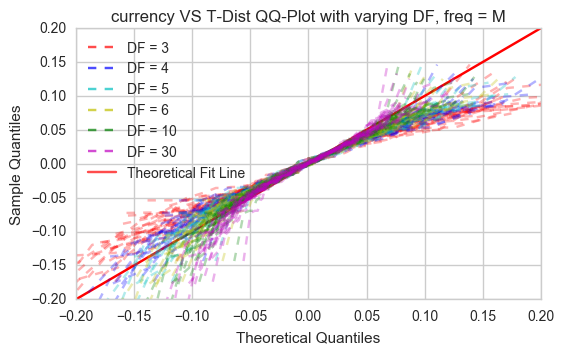

In [166]:
t_dist_qq(asset_class='currency', freq='M', alpha=0.3)

# ETFs Q-Q Plot

### T-Distributions, varying degrees of freedom, Daily returns

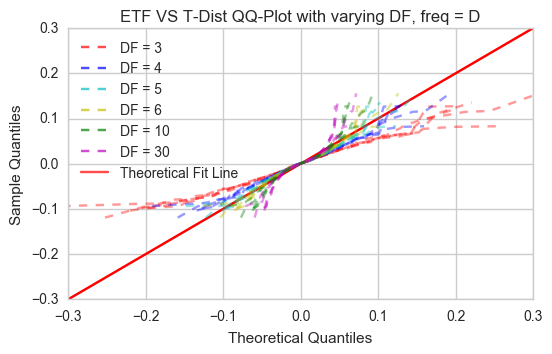

In [160]:
t_dist_qq(asset_class='ETF', alpha=0.4)

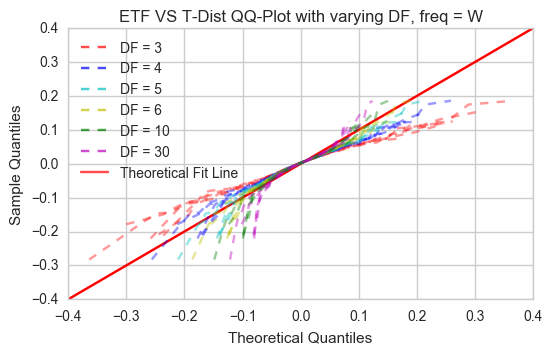

In [161]:
t_dist_qq(asset_class='ETF', freq='W', alpha=0.4)

# ETFs Q-Q Plot

### T-Distributions, varying degrees of freedom, Monthly returns

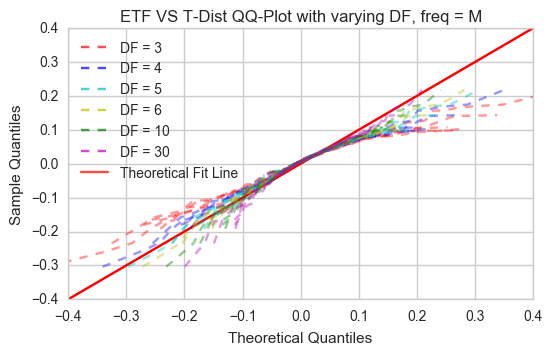

In [167]:
t_dist_qq(asset_class='ETF', freq='M', alpha=0.4)

# Equities Q-Q Plot

### T-Distributions, varying degrees of freedom, Daily returns

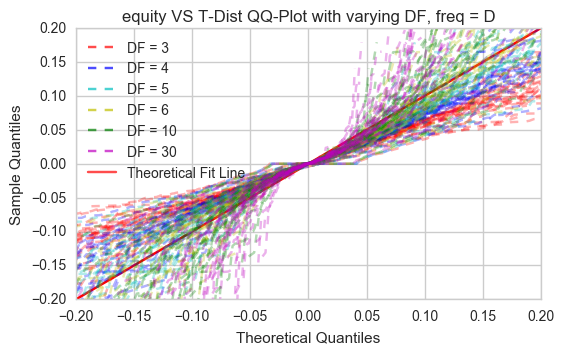

In [163]:
np.random.seed(178349)
t_dist_qq(asset_class='equity', freq='D', alpha=0.3)

# Equities Q-Q Plot

### T-Distributions, varying degrees of freedom, Weekly returns

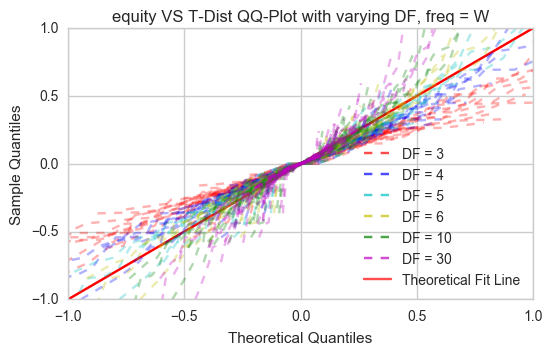

In [164]:
np.random.seed(178349)
t_dist_qq(asset_class='equity', freq='W', alpha=0.3)

# Equities Q-Q Plot

### T-Distributions, varying degrees of freedom, Monthly returns

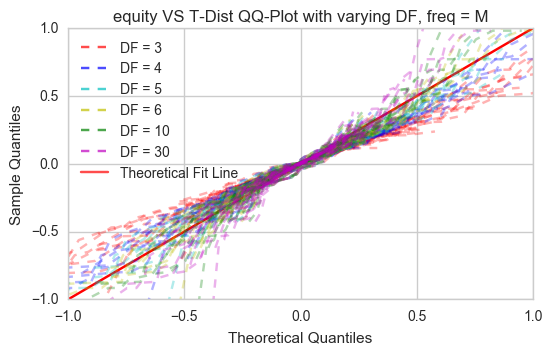

In [165]:
np.random.seed(178349)
t_dist_qq(asset_class='equity', freq='M', alpha=0.3)

**T-Distribution Conclusion**
- It appears that for T-Distributions, 4 or 5 degrees of freedom has the Best fit.
    - This has not been quantified, only eyed.

# Kolmogorov–Smirnov test

The [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) is a test for equality of two distributions by measuring differenecs in their cumulative density functions. Here we can use this test to determine if the observed market returns are coming from the distributions previously examined, namely the laplace and the T distributions.

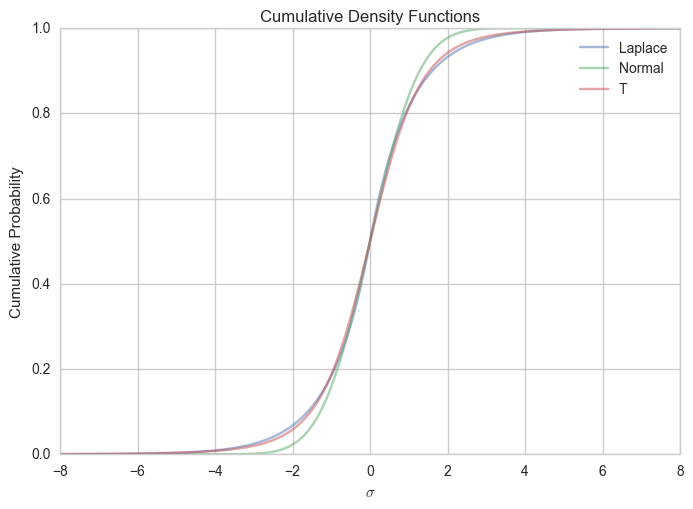

In [129]:
x = np.linspace(-8,8,150)
dists = [stats.laplace, stats.norm, stats.t(df=4)]
for dist in dists:
    plt.plot(x, dist.cdf(x), alpha=0.5)
    
plt.xlabel('$\sigma$')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Density Functions')
plt.legend(['Laplace','Normal','T'],loc='best');

#### Running the KS-Test for the S&P 500.

In [133]:
# Normal Distribution KS-Test, SPY returns
SPY = data.equities.ETFs['SPY']
spy_mean = np.mean(SPY.returns)
spy_std = np.std(SPY.returns)
dist = stats.norm(loc=spy_mean, scale=spy_std)
ks_stat, p_value = stats.kstest(SPY.returns.values, dist.cdf)
cutoff = 0.05
print('SPY vs Normal Dist')
print('SPY KS-stat: ',ks_stat)
if p_value <= cutoff:
    print('p-value = ',p_value,' <= '+str(cutoff)+', therefore we reject the null ',
          'hypothesis that the returns are normally distributed')
else:
    print('p-value = ',p_value,' > '+str(cutoff)+', therefore we fail to reject the null ',
          'hypothesis that the returns are normally distributed')

SPY vs Normal Dist
SPY KS-stat:  0.0879741942651
p-value =  5.47037140078e-41  <= 0.05, therefore we reject the null  hypothesis that the returns are normally distributed


In [146]:
# Laplace Distribution KS-Test, SPY returns (Weekly)
SPY = data.equities.ETFs['SPY']

pricing = SPY.pricing['Adj Close'].resample('W').last()
returns = np.log(1 + pricing.pct_change())[1:]

loc, scale = stats.norm.fit(returns.values)
dist = stats.norm(loc=loc, scale=scale)
ks_stat, p_value = stats.kstest(returns.values, dist.cdf)
cutoff = 0.05
print('SPY vs Normal Dist')
print('SPY KS-stat: ',ks_stat)
if p_value <= cutoff:
    print('p-value = ',p_value,' <= '+str(cutoff)+', therefore we reject the null ',
          'hypothesis that the return distribution is a Normal distribution')
else:
    print('p-value = ',p_value,' > '+str(cutoff)+', therefore we fail to reject the null ',
          'hypothesis that the return distribution is a Normal distribution')

SPY vs Normal Dist
SPY KS-stat:  0.0661401483047
p-value =  3.37675978261e-05  <= 0.05, therefore we reject the null  hypothesis that the return distribution is a Normal distribution


In [144]:
# Laplace Distribution KS-Test, SPY returns
SPY = data.equities.ETFs['SPY']

loc, scale = stats.laplace.fit(SPY.returns.values)
dist = stats.laplace(loc=loc, scale=scale)
ks_stat, p_value = stats.kstest(SPY.returns.values, dist.cdf)
cutoff = 0.05
print('SPY vs Laplace Dist')
print('SPY KS-stat: ',ks_stat)
if p_value <= cutoff:
    print('p-value = ',p_value,' <= '+str(cutoff)+', therefore we reject the null ',
          'hypothesis that the return distribution is a Laplace distribution')
else:
    print('p-value = ',p_value,' > '+str(cutoff)+', therefore we fail to reject the null ',
          'hypothesis that the return distribution is a Laplace distribution')

SPY vs Laplace Dist
SPY KS-stat:  0.0172287039657
p-value =  0.0556319530599  > 0.05, therefore we fail to reject the null  hypothesis that the return distribution is a Laplace distribution


In [145]:
#Weekly returns SPY, Laplace dist.
pricing = SPY.pricing['Adj Close'].resample('W').last()
returns = np.log(1 + pricing.pct_change())[1:]

loc, scale = stats.laplace.fit(returns.values)
dist = stats.laplace(loc=loc, scale=scale)
ks_stat, p_value = stats.kstest(returns.values, dist.cdf)
cutoff = 0.05
print('SPY Weekly Returns vs Laplace Dist')
print('SPY KS-stat: ',ks_stat)
if p_value <= cutoff:
    print('p-value = ',p_value,' <= '+str(cutoff)+', therefore we reject the null ',
          'hypothesis that the return distribution is a Laplace distribution')
else:
    print('p-value = ',p_value,' > '+str(cutoff)+', therefore we fail to reject the null ',
          'hypothesis that the return distribution is a Laplace distribution')

SPY Weekly Returns vs Laplace Dist
SPY KS-stat:  0.0251332185178
p-value =  0.405454115266  > 0.05, therefore we fail to reject the null  hypothesis that the return distribution is a Laplace distribution


In [155]:
# Daily returns, T dist
returns = SPY.returns
df = 4
_df_fit ,loc, scale = stats.t.fit(returns.values)
dist = stats.t(df=df, loc=loc, scale=scale)
ks_stat, p_value = stats.kstest(returns.values, dist.cdf)
cutoff = 0.05
print('SPY Weekly Returns vs T Dist')
print('SPY KS-stat: ',ks_stat)
if p_value <= cutoff:
    print('p-value = ',p_value,' <= '+str(cutoff)+', therefore we reject the null ',
          'hypothesis that the return distribution is a T distribution')
else:
    print('p-value = ',p_value,' > '+str(cutoff)+', therefore we fail to reject the null ',
          'hypothesis that the return distribution is a T distribution')

SPY Weekly Returns vs T Dist
SPY KS-stat:  0.0295880536187
p-value =  5.16087863882e-05  <= 0.05, therefore we reject the null  hypothesis that the return distribution is a T distribution


In [156]:
#Weekly returns, SPY, T-Dist
pricing = SPY.pricing['Adj Close'].resample('W').last()
returns = np.log(1 + pricing.pct_change())[1:]

df = 4
_df_fit ,loc, scale = stats.t.fit(returns.values)
dist = stats.t(df=df, loc=loc, scale=scale)
ks_stat, p_value = stats.kstest(returns.values, dist.cdf)
cutoff = 0.05
print('SPY Weekly Returns vs T Dist')
print('SPY KS-stat: ',ks_stat)
if p_value <= cutoff:
    print('p-value = ',p_value,' <= '+str(cutoff)+', therefore we reject the null ',
          'hypothesis that the return distribution is a T distribution')
else:
    print('p-value = ',p_value,' > '+str(cutoff)+', therefore we fail to reject the null ',
          'hypothesis that the return distribution is a T distribution')

SPY Weekly Returns vs T Dist
SPY KS-stat:  0.0231592634893
p-value =  0.513874021129  > 0.05, therefore we fail to reject the null  hypothesis that the return distribution is a T distribution


### SPY KS-Test Results

After running a few ks-tests for the distributions of interest on the daily and weekly time frames for the SPY, it seems like we can again reject the hypothesis that SPY returns are normally distributed. From the few tests that I ran, we could not reject the null hypothesis with the Laplace distribution on the daily or weekly time frames. This was to be expected after viewing the corresponding QQ-plots. For the SPY, the T distribution was not as good of a fit for the daily data as the laplace distribution. From these few tests it seems that the T distribution and Laplace distribution represent market returns better than the normal distribution, but again not perfectly. The KS-tests above were only run for the SPY. Below I have written a function that will perform many KS-tests accross many assets and return the results. This way I can see how the distributions fit a bucket of equity and currency returns.

## Running Multiple KS-Tests Across Multiple Assets

In [115]:
def multiple_ks_test(asset_class='ETF', dist=stats.norm , df=4, freq='D', seed=2888):
    
    if asset_class == 'ETF':
        num_etfs = len(data.equities.ETFs)
        ks_stats = np.zeros(num_etfs)
        p_values = np.zeros(num_etfs)
    elif asset_class == 'equity':
        num_equities = 35
        ks_stats = np.zeros(num_equities)
        p_values = np.zeros(num_equities)
    if asset_class == 'currency':
        num_pairs = 0
        for base in data.currencies:
            for pair in base:
                num_pairs += 1
        ks_stats = np.zeros(num_pairs)
        p_values = np.zeros(num_pairs)
    
    if asset_class == 'currency':
        counter = 0
        for base in data.currencies:
            for pair in base:
                if freq != 'H':
                    pricing = pair.pricing['closeAsk'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = pair.returns    
                returns = returns.dropna()
                asset_mean = np.mean(returns)
                asset_std = np.std(returns)
                if isinstance(dist, type(stats.t)):
                    dist_fit = dist(df=df, loc=asset_mean, scale=asset_std)
                else:
                    dist_fit = dist(loc=asset_mean, scale=asset_std)
                results = stats.kstest(returns, dist_fit.cdf)
                ks_stats[counter] = results[0]
                p_values[counter] = results[1]
                counter += 1
                
    else:
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            if seed != None:
                np.random.seed(seed)
            assets = data.equities.random_selection(size=num_equities)
        for i in range(len(assets)):
            if freq != 'D':
                pricing = assets[i].pricing['Adj Close'].resample(freq).last()
                returns = np.log(1 + pricing.pct_change())[1:]
            else:
                returns = assets[i].returns
            returns = returns.dropna()
            asset_mean = np.mean(returns)
            asset_std = np.std(returns)
            if isinstance(dist, type(stats.t)):
                dist_fit = dist(df=df, loc=asset_mean, scale=asset_std)
            else:
                dist_fit = dist(loc=asset_mean, scale=asset_std)
            results = stats.kstest(returns.values, dist_fit.cdf)
            ks_stats[i] = results[0]
            p_values[i] = results[1]
    
    ks_stats = ks_stats[~np.isnan(ks_stats)]
    p_values = p_values[~np.isnan(p_values)]
    
    ks_stat_ave = np.nansum(ks_stats) / float(len(ks_stats))
    p_value_ave = np.nansum(p_values) / float(len(p_values))
    
    return ks_stat_ave, p_value_ave, ks_stats, p_values

In [116]:
def run_mlt_ks_test(asset_class='ETF', dist=stats.norm, cutoff=0.05, df=4, seed=2888):
    TFs = ['H','D','W','M','6M','A']
    if asset_class != 'currency':
        TFs = TFs[1:]
    a = np.empty((len(TFs),7))
    a[:] = np.nan
    
    data_f = DataFrame(a,columns=['asset_class','time_frame','distribution','degrees_of_freedom',
                              'failed_tests','total_tests','average_p_value'])
    
    for i in range(len(TFs)):
        ks_stat_ave, p_value_ave, ks_stats, p_values = multiple_ks_test(asset_class=asset_class,
                                                                dist=dist, df=df, freq=TFs[i],seed=seed)
        failures = len(p_values[p_values <  cutoff])
        if isinstance(dist, type(stats.t)):
            data_f.iloc[i,:] = [asset_class, TFs[i], dist.name, df, failures, len(p_values), p_value_ave]
        else:
            data_f.iloc[i,:] = [asset_class, TFs[i], dist.name, np.nan, failures, len(p_values), p_value_ave]
            
    
    return data_f

In [142]:
def multi_asset_ks_test(seed=2888, dists=[stats.laplace, stats.norm, stats.t], DFs = [3,4,5,6,7,8,9,10]):
    asset_classes = ['equity','currency','ETF']
    ks_data = DataFrame()
    
    for asset_class in asset_classes:
        for dist in dists:
            if isinstance(dist, type(stats.t)):
                for df in DFs:
                    ks_frame = run_mlt_ks_test(asset_class=asset_class, dist=dist, df=df, seed=seed)
                    ks_data = pd.concat([ks_data, ks_frame], ignore_index=True)
            else:
                ks_frame = run_mlt_ks_test(asset_class=asset_class, dist=dist, seed=seed)
                ks_data = pd.concat([ks_data, ks_frame], ignore_index=True)
    return ks_data

In [143]:
results = multi_asset_ks_test()

In [121]:
# results_nf = results[results.failed_tests != results.total_tests]

In [144]:
results_failed_sorted = results.sort_values(by='failed_tests')

In [145]:
results_failed_sorted['pct_failed'] = results_failed_sorted.failed_tests / results_failed_sorted.total_tests

In [146]:
ts = results_failed_sorted[results_failed_sorted.distribution == 't']
t_3 = ts[ts.degrees_of_freedom == 3]
t_4 = ts[ts.degrees_of_freedom == 4]
t_5 = ts[ts.degrees_of_freedom == 5]
t_6 = ts[ts.degrees_of_freedom == 6]
t_7 = ts[ts.degrees_of_freedom == 7]
t_8 = ts[ts.degrees_of_freedom == 8]
t_9 = ts[ts.degrees_of_freedom == 9]
t_10 = ts[ts.degrees_of_freedom == 10]
ls = results_failed_sorted[results_failed_sorted.distribution == 'laplace']
ns = results_failed_sorted[results_failed_sorted.distribution == 'norm']

### KS Test Results

Here we have some of the KS test results across multipe assets, time frames and data.

In [147]:
t_3_ave = t_3.pct_failed.sum() / len(t_3.pct_failed)
t_4_ave = t_4.pct_failed.sum() / len(t_4.pct_failed)
t_5_ave = t_5.pct_failed.sum() / len(t_5.pct_failed)
t_6_ave = t_6.pct_failed.sum() / len(t_6.pct_failed)
t_7_ave = t_7.pct_failed.sum() / len(t_7.pct_failed)
t_8_ave = t_8.pct_failed.sum() / len(t_8.pct_failed)
t_9_ave = t_9.pct_failed.sum() / len(t_9.pct_failed)
t_10_ave = t_10.pct_failed.sum() / len(t_10.pct_failed)
l_ave = ls.pct_failed.sum() / len(ls.pct_failed)
n_ave = ns.pct_failed.sum() / len(ns.pct_failed)

print('T Distribution, df = 3, total fail rate: ',t_3_ave)
print('T Distribution, df = 4, total fail rate: ',t_4_ave)
print('T Distribution, df = 5, total fail rate: ',t_5_ave)
print('T Distribution, df = 6, total fail rate: ',t_6_ave)
print('T Distribution, df = 7, total fail rate: ',t_7_ave)
print('T Distribution, df = 8, total fail rate: ',t_8_ave)
print('T Distribution, df = 9, total fail rate: ',t_9_ave)
print('T Distribution, df = 10, total fail rate: ',t_10_ave)
print('Laplace Distribution total fail rate: ',l_ave)
print('Normal Distribution total fail rate: ',n_ave)

T Distribution, df = 3, total fail rate:  0.501339285714
T Distribution, df = 4, total fail rate:  0.480803571429
T Distribution, df = 5, total fail rate:  0.470982142857
T Distribution, df = 6, total fail rate:  0.462946428571
T Distribution, df = 7, total fail rate:  0.459375
T Distribution, df = 8, total fail rate:  0.457142857143
T Distribution, df = 9, total fail rate:  0.453571428571
T Distribution, df = 10, total fail rate:  0.453571428571
Laplace Distribution total fail rate:  0.463839285714
Normal Distribution total fail rate:  0.428571428571


The results are not what was expected. The fail rates of the null hypothesis for the tests was near $50%$ for all of the distributions.

## Examining KS Test Results on Different Time Frames

All time frames are included in these calculations, with each distribution representing the time frames differenly. Perhaps isolating the time frames would help to shine a different light on the results.

In [159]:
results_failed_sorted = results_failed_sorted.sort_values(by='pct_failed')
results_failed_sorted['time_frame_order'] = results_failed_sorted.time_frame
results_failed_sorted.time_frame_order = results_failed_sorted.time_frame_order.replace({'H':0, 'D':1, 'W':2,
                                                                                         'M':3, '6M':4, 'A':5, })
results_failed_sorted = results_failed_sorted.sort_values(by='time_frame_order')
results_failed_sorted.index = range(len(results_failed_sorted))

ts = results_failed_sorted[results_failed_sorted.distribution == 't']

t_3 = ts[ts.degrees_of_freedom == 3].copy()
t_4 = ts[ts.degrees_of_freedom == 4].copy()
t_5 = ts[ts.degrees_of_freedom == 5].copy()
t_6 = ts[ts.degrees_of_freedom == 6].copy()
t_7 = ts[ts.degrees_of_freedom == 7].copy()
t_8 = ts[ts.degrees_of_freedom == 8].copy()
t_9 = ts[ts.degrees_of_freedom == 9].copy()
t_10 = ts[ts.degrees_of_freedom == 10].copy()
ls = results_failed_sorted[results_failed_sorted.distribution == 'laplace'].copy()
ns = results_failed_sorted[results_failed_sorted.distribution == 'norm'].copy()

Because the same number of tests were run for each of these distributions we can do a cumulative sum.

In [160]:
t_3['cum_pct_failed'] = t_3.pct_failed.cumsum()
t_4['cum_pct_failed'] = t_4.pct_failed.cumsum()
t_5['cum_pct_failed'] = t_5.pct_failed.cumsum()
t_6['cum_pct_failed'] = t_6.pct_failed.cumsum()
t_7['cum_pct_failed'] = t_7.pct_failed.cumsum()
t_8['cum_pct_failed'] = t_8.pct_failed.cumsum()
t_9['cum_pct_failed'] = t_9.pct_failed.cumsum()
t_10['cum_pct_failed'] = t_10.pct_failed.cumsum()
ls['cum_pct_failed'] = ls.pct_failed.cumsum()
ns['cum_pct_failed'] = ns.pct_failed.cumsum()

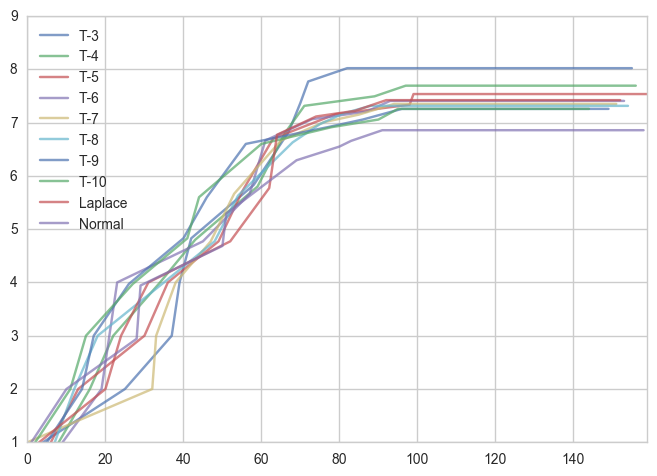

In [168]:
t_3.cum_pct_failed.plot(alpha=0.7, label='T-3')
t_4.cum_pct_failed.plot(alpha=0.7, label='T-4')
t_5.cum_pct_failed.plot(alpha=0.7, label='T-5')
t_6.cum_pct_failed.plot(alpha=0.7, label='T-6')
t_7.cum_pct_failed.plot(alpha=0.7, label='T-7')
t_8.cum_pct_failed.plot(alpha=0.7, label='T-8')
t_9.cum_pct_failed.plot(alpha=0.7, label='T-9')
t_10.cum_pct_failed.plot(alpha=0.7, label='T-10')
ls.cum_pct_failed.plot(alpha=0.7, label='Laplace')
ns.cum_pct_failed.plot(alpha=0.7, label='Normal')

plt.legend(loc='best')
ax1 = plt.gca();

The plot above may be hard to interpret. It shows the cumulative sum of the failed test percentage for each of the distributions on the $y$ axis, and on the $x$ axis is the time frame from smallest to largest. The time frame $x$ axis is represented with numbers which represent the rows in the dataframe which is sorted by timeframes; $H, D, W, M, 6M, A.$ This can be interpreted as the the lower the line is for a distribution at any given x, value, the fewer tests it has failed, and the therefore the better fit it is on the preceding time frames. I am most interested in the smaller time frames, namely H, D, and W. From the previous tests these seem to have the fattest tails. This makes sense because as more time passes, the wild market returns might be corrected by price movements. This would suggest a mean reverting aspect.

Although it is usually not recommended that the p-value be looked at as a indicator of the score of a test, but instead recommended to be used as a cutoff of significance, we can still take a look at the cumulative average p-value for the tests in a similar manner.

In [169]:
t_3['cum_average_p_value'] = t_3.average_p_value.cumsum()
t_4['cum_average_p_value'] = t_4.average_p_value.cumsum()
t_5['cum_average_p_value'] = t_5.average_p_value.cumsum()
t_6['cum_average_p_value'] = t_6.average_p_value.cumsum()
t_7['cum_average_p_value'] = t_7.average_p_value.cumsum()
t_8['cum_average_p_value'] = t_8.average_p_value.cumsum()
t_9['cum_average_p_value'] = t_9.average_p_value.cumsum()
t_10['cum_average_p_value'] = t_10.average_p_value.cumsum()
ls['cum_average_p_value'] = ls.average_p_value.cumsum()
ns['cum_average_p_value'] = ns.average_p_value.cumsum()

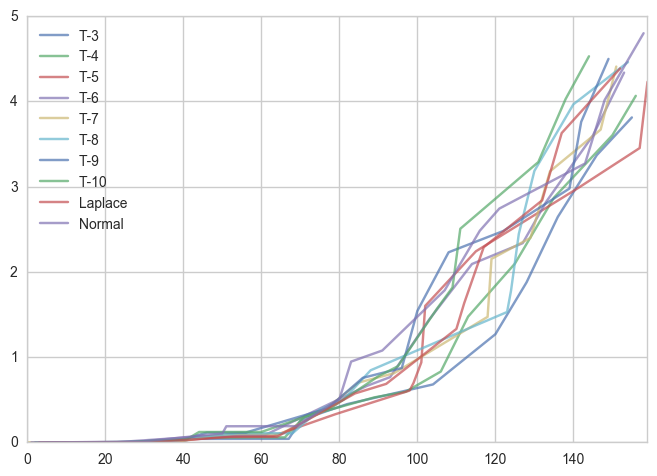

In [176]:
t_3.cum_average_p_value.plot(alpha=0.7, label='T-3')
t_4.cum_average_p_value.plot(alpha=0.7, label='T-4')
t_5.cum_average_p_value.plot(alpha=0.7, label='T-5')
t_6.cum_average_p_value.plot(alpha=0.7, label='T-6')
t_7.cum_average_p_value.plot(alpha=0.7, label='T-7')
t_8.cum_average_p_value.plot(alpha=0.7, label='T-8')
t_9.cum_average_p_value.plot(alpha=0.7, label='T-9')
t_10.cum_average_p_value.plot(alpha=0.7, label='T-10')
ls.cum_average_p_value.plot(alpha=0.7, label='Laplace')
ns.cum_average_p_value.plot(alpha=0.7, label='Normal')

plt.legend(loc='best')
ax1 = plt.gca();

This would suggest that the T-Distributions with 3, 4, and 5 degrees of freedom are the best fitting distributions becuse they are following the bottom of the plotted group of lines.

The results of the KS-tests seem rather unexpected and this may be due to the fact that the test's weekness is insensitivity to differences in the tails of distributions as described [here](https://asaip.psu.edu/Articles/beware-the-kolmogorov-smirnov-test). This would explain why maybe this test is not the best choice for my research.

# Distribution Conclusion

It is very apparent that market returns do not exhibit a normal distribution. There are, howerver, time frames where the returns become more normal, expecially at the higher timeframes like annual rates of returns. This is a stretch though because I only have about 25 data points for the annual time frame in this study. The data shows that market returns are leptokurtic (fat tailed) especially at smaller time frames; hours, days, weeks. The data also indicates that market returns are also somehwat negatively skewed, especially at the larger time frames; monthly, semi-annually, and annually. This means that large negative returns are more freqent than large positive returns. This is bad for many investors who primarilly trade long in the market. Long in this context means to purchase or buy an asset to gain from its increase in value.

# Autocorrelation

 - The potential presence of positive autocorrelated returns is a potential contributing factor to why equity and currency markets exhibit fat tailed return distributions. 
 - **Autocorrelation** is present when values in a time series are correlated with other values in the series at other points in time, i.e., **lagging self-correlation**.
 - autocorrelative effect if: previous 2 periods showed positive returns then as a result the current period's returns were on average positive or expected to be positive.

# Autocorrelation

This section will be brief. I would like to quickly explore the idea of autocorrelation and the role it plays in market returns. [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) occurs when values in a time series are correlated with other values in the series at other points in time (lagging data). For example, we could say that returns show autocorrelation if the previous 2 days showed positive returns and if as a result today's returns were on average positive. An example of negative autocorrelation would be if the previous 4 days showed positive returns, then todays returns were more likely to be negative.



Luckily, pandas has a few nice built in functions to check for autocorrelation as well as plot the relationship.

In [168]:
from pandas.tools.plotting import autocorrelation_plot

In [169]:
autocorrelation_plot??

In [173]:
def plot_autocorr(asset):
    autocorrelation_plot(asset)
    plt.ylim(-0.2,0.2)
    plt.xlim(0,50)
    fig = plt.gcf()
    fig.set_size_inches(6,3.5)
    plt.legend(['$95\%$','$99\%$','Observed'])
    plt.title('SPY Daily Return Autocorrelation')
    print('1 day lag autocorrelation for the SPY: ', data.equities.ETFs['SPY'].returns.autocorr(1))
    print('2 day lag autocorrelation for the SPY: ', data.equities.ETFs['SPY'].returns.autocorr(2))

1 day lag autocorrelation for the SPY:  -0.0609509544731
2 day lag autocorrelation for the SPY:  -0.0536131739516


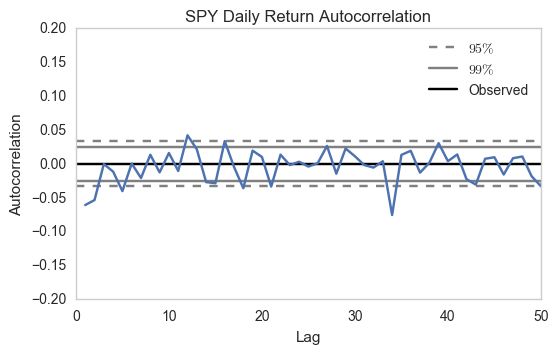

In [174]:
plot_autocorr(data.equities.ETFs['SPY'].returns)

1 day lag autocorrelation for the DIA:  -0.0761354794708
2 day lag autocorrelation for the DIA:  -0.0414677503813


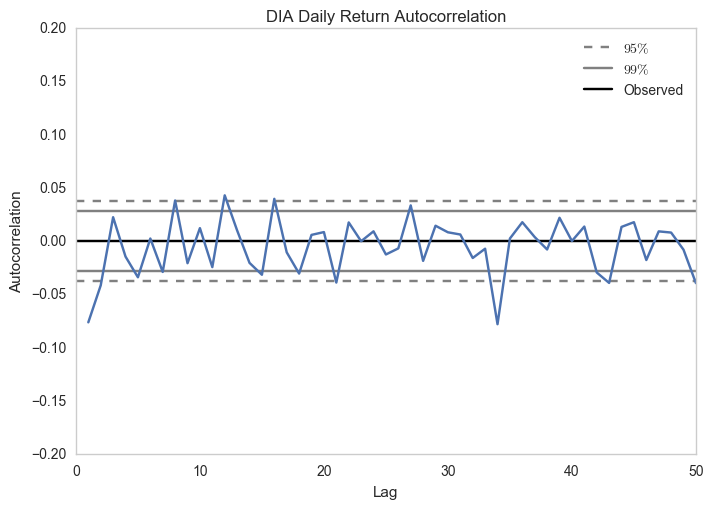

In [197]:
autocorrelation_plot(data.equities.ETFs['DIA'].returns)
plt.ylim(-0.2,0.2)
plt.xlim(0,50)
plt.legend(['$95\%$','$99\%$','Observed'])
plt.title('DIA Daily Return Autocorrelation')
print('1 day lag autocorrelation for the DIA: ', data.equities.ETFs['DIA'].returns.autocorr(1))
print('2 day lag autocorrelation for the DIA: ', data.equities.ETFs['DIA'].returns.autocorr(2))

In [ ]:
autocorrelation_plot()

In [175]:
def multi_ac_plot(asset_class='ETF', freq='D', alpha=0.5):
    fig, ax2 = plt.subplots()
    fig.set_size_inches(6,3.5)

    if asset_class == 'currency':
        for base in data.currencies:
            for pair in base:
                if freq != 'H':
                    pricing = pair.pricing['closeAsk'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = pair.returns    
                returns = returns.dropna()
                autocorrelation_plot(returns, ax=ax2)
    else:
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            assets = data.equities.random_selection(size=35)
        for asset in assets:
            if freq != 'D':
                pricing = asset.pricing['Adj Close'].resample(freq).last()
                returns = np.log(1 + pricing.pct_change())[1:]
            else:
                returns = asset.returns
            returns = returns.dropna()
            autocorrelation_plot(returns, ax=ax2)
            
    for i in range(len(ax2.lines)-1, 0, -1):
        if i%3 == 2:
            ax2.lines[i].set_alpha(alpha)
        elif i > 4:
            ax2.lines.remove(ax2.lines[i])
    
    plt.xlim(0,40)
    plt.ylim(-0.3,0.3)
    plt.title(asset_class+' Autocorrelation, frequency = '+freq)

# Autocorrelation ETFs

### Daily Time Frame

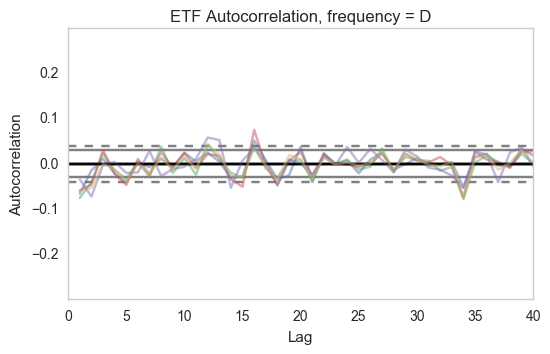

In [176]:
multi_ac_plot(asset_class='ETF', freq='D')

# Autocorrelation ETFs

### Weekly Time Frame

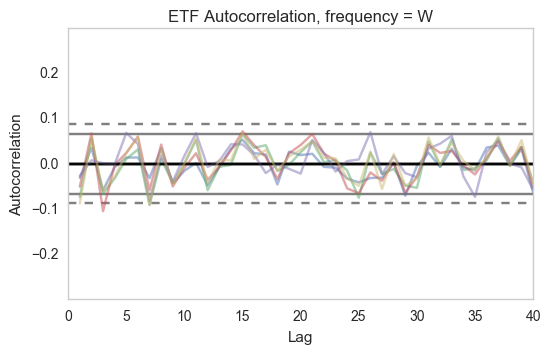

In [177]:
multi_ac_plot(asset_class='ETF', freq='W')

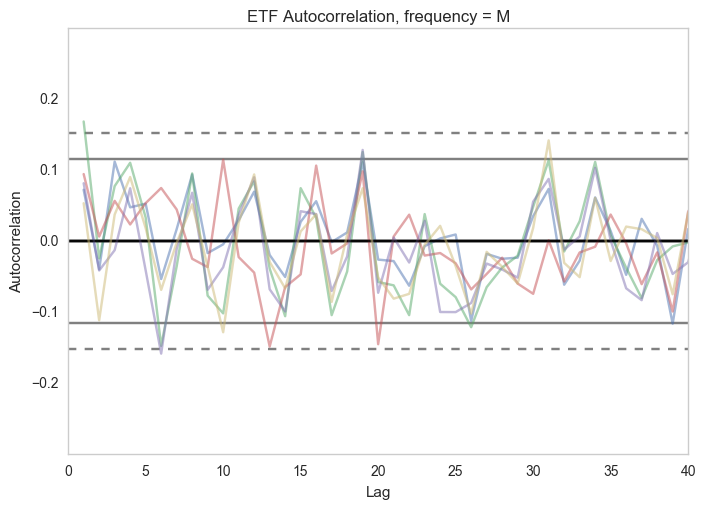

In [39]:
multi_ac_plot(asset_class='ETF', freq='M')

# Autocorrelation Currencies

### Hourly Time Frame

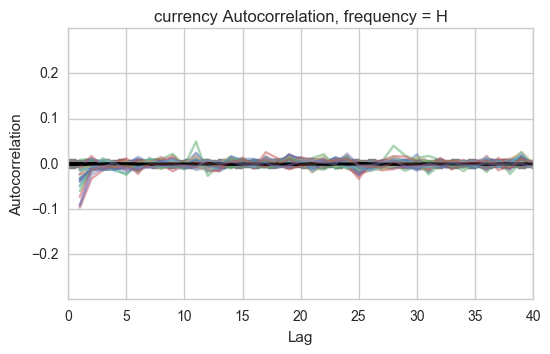

In [178]:
multi_ac_plot(asset_class='currency', freq='H')

# Autocorrelation Currencies

### Daily Time Frame

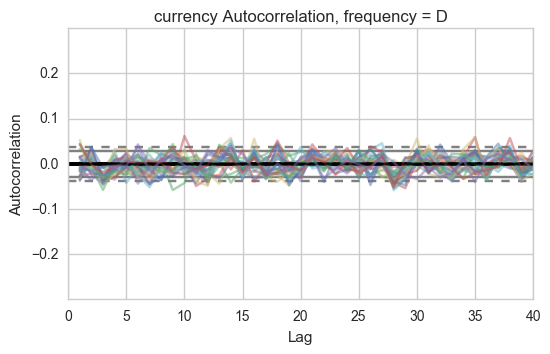

In [179]:
multi_ac_plot(asset_class='currency', freq='D')

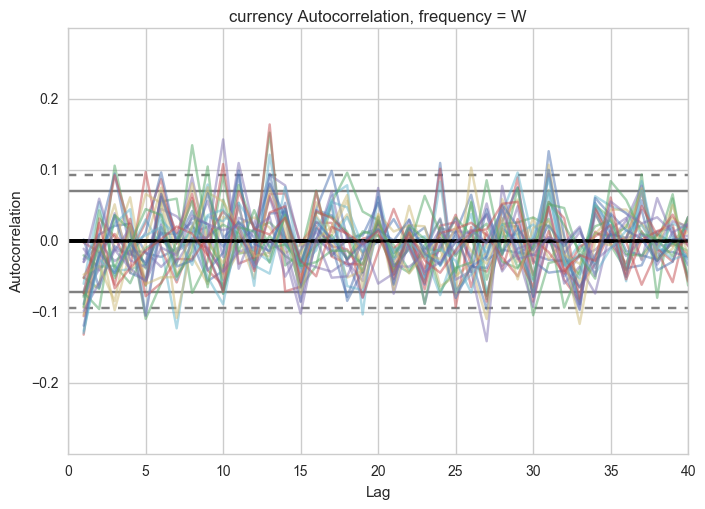

In [42]:
multi_ac_plot(asset_class='currency', freq='W')

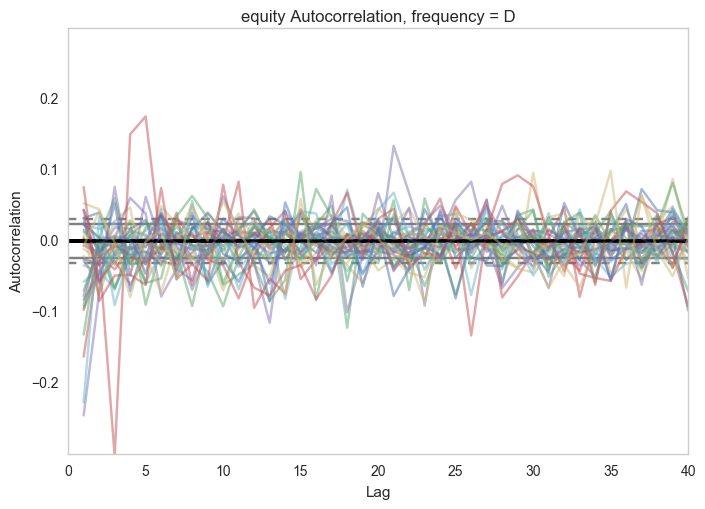

In [11]:
np.random.seed(448855)
multi_ac_plot(asset_class='equity', freq='D')

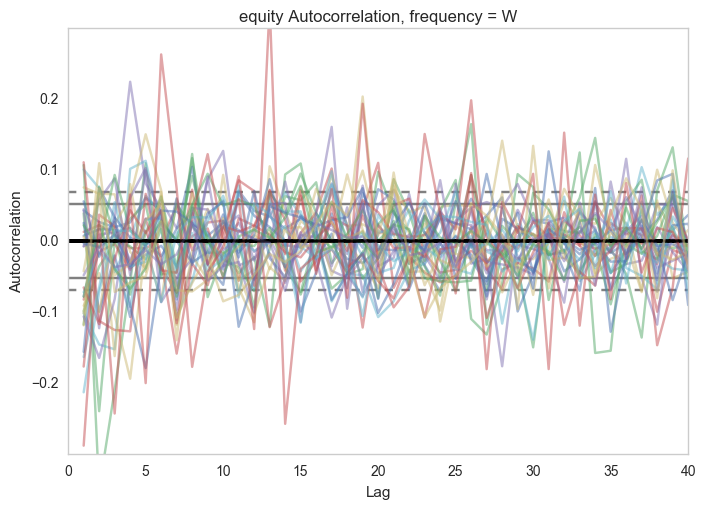

In [12]:
np.random.seed(448855)
multi_ac_plot(asset_class='equity', freq='W')

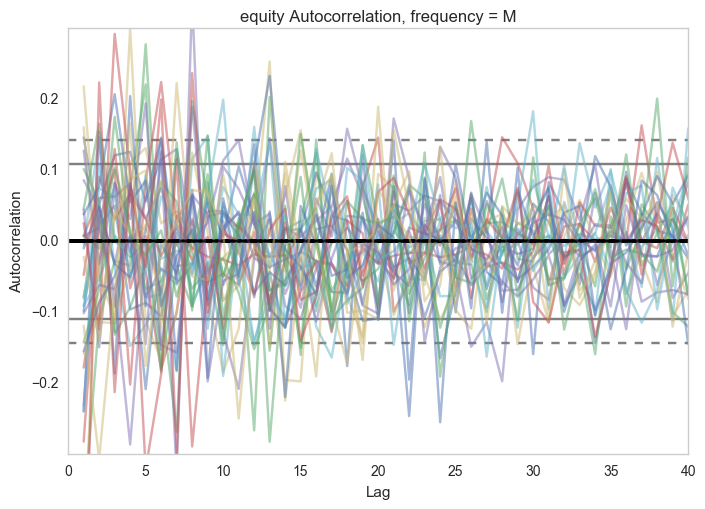

In [13]:
np.random.seed(448855)
multi_ac_plot(asset_class='equity', freq='M')

In [180]:
def ac_moving_ave_hist(period=3, freq='D', lag=1, seed=4312, bins=15):
    if seed != None:
        np.random.seed(seed)
    n=0
    for asset_class in ['ETF','equity','currency']:
        corr_list = []
        if asset_class == 'currency':
            for base in data.currencies:
                for pair in base:
                    if freq != 'H':
                        pricing = pair.pricing['closeAsk'].resample(freq).last()
                        returns = np.log(1 + pricing.pct_change())[1:]
                    else:
                        returns = pair.returns    
                    returns = returns.dropna()
                    MA_returns = returns.rolling(window=period).mean()[period-1:]
                    n = len(MA_returns)
                    corr = returns.corr(MA_returns.shift(lag))
                    corr_list.append(corr)
        else:
            if asset_class == 'ETF':
                assets = list(data.equities.ETFs.values())
            else:
                assets = data.equities.random_selection(size=35)
            for asset in assets:
                if freq != 'D':
                    pricing = asset.pricing['Adj Close'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = asset.returns
                returns = returns.dropna()
                MA_returns = returns.rolling(window=period).mean()[period-1:]
                n = len(MA_returns)
                corr = returns.corr(MA_returns.shift(lag))
                corr_list.append(corr)

        plt.hist(corr_list, alpha=0.5, label=asset_class)
    z95 = 1.959963984540054
    z99 = 2.5758293035489004
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(6,3.5)
    ax.axvline(x=z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.axvline(x=z95 / np.sqrt(n), color='grey')
    ax.axvline(x=0.0, color='black')
    ax.axvline(x=-z95 / np.sqrt(n), color='grey')
    ax.axvline(x=-z99 / np.sqrt(n), linestyle='--', color='grey')
    plt.xlabel('correlation')
    plt.legend(['$99\%$','$95\%$','center','$95\%$','$99\%$','ETF','equity','currency'],loc='best')
    plt.ylabel('Occurrence')
    plt.title('Correlation of Assets with MA = '+str(period)+' period, frequency = '+freq+', lag = '+str(lag))

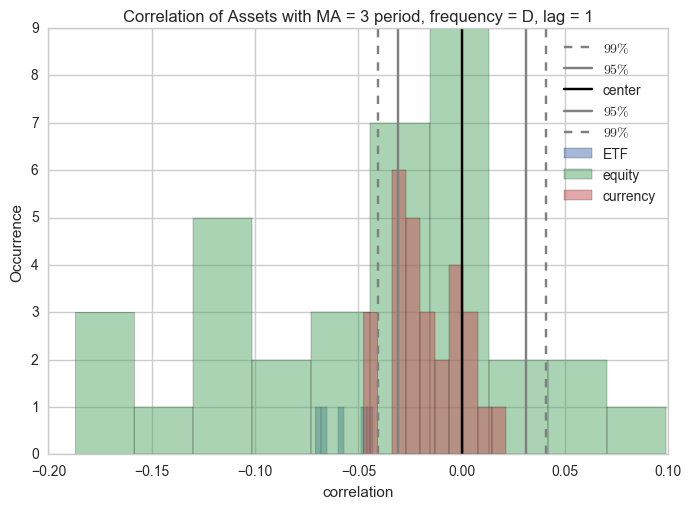

In [28]:
ac_moving_ave_hist()

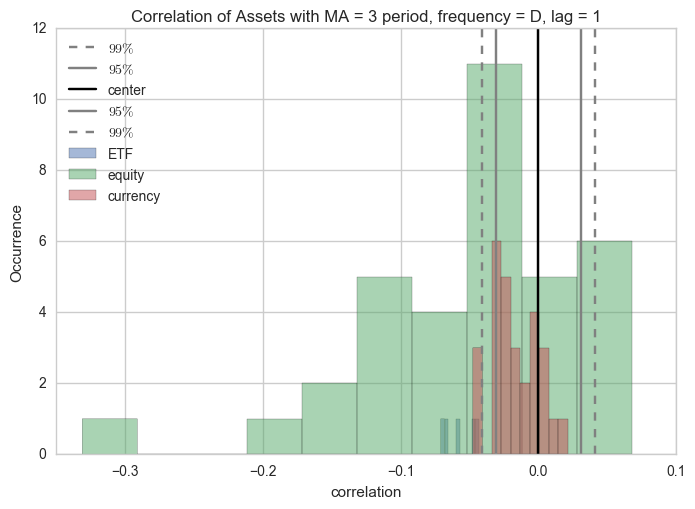

In [29]:
ac_moving_ave_hist(seed=6665)

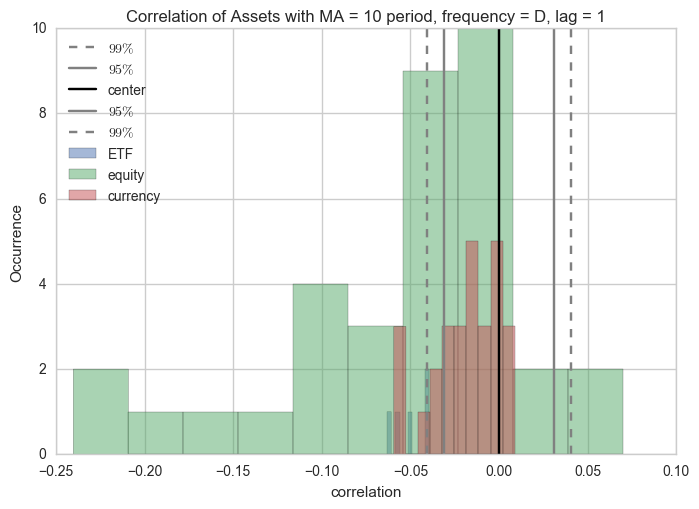

In [31]:
ac_moving_ave_hist(period=10, seed=6665)

In [74]:
def ac_ma_plot(asset_class='ETF', end=50, lag=1, seed=718, freq='D'):
    if seed != None:
        np.random.seed(seed)
    n=0
    MAs = range(end+1)
    corr_list = []
    if asset_class == 'currency':
        pairs_list = []
        for base in data.currencies:
            for pair in base:
                pairs_list.append(pair)
        ac_ma_data = DataFrame(np.zeros((len(range(end+1)),len(pairs_list))),
                               columns=[pair.pair_name for pair in pairs_list])
        for pair in pairs_list:
            if freq != 'H':
                pricing = pair.pricing['closeAsk'].resample(freq).last()
                returns = np.log(1 + pricing.pct_change())[1:]
            else:
                returns = pair.returns    
            returns = returns.dropna()
            for ma in MAs:
                MA_returns = returns.rolling(window=ma).mean()[ma-1:]
                corr = returns.corr(MA_returns.shift(lag))
                ac_ma_data.loc[ma,pair.pair_name] = corr
            n = len(MA_returns)
    else:
        if asset_class == 'ETF':
            assets = list(data.equities.ETFs.values())
        else:
            assets = data.equities.random_selection(size=35)
        ac_ma_data = DataFrame(np.zeros((len(range(end+1)),len(assets))),
                               columns=[asset.symbol for asset in assets])
        for asset in assets:
            for ma in MAs:
                if freq != 'D':
                    pricing = asset.pricing['Adj Close'].resample(freq).last()
                    returns = np.log(1 + pricing.pct_change())[1:]
                else:
                    returns = asset.returns
                returns = returns.dropna()
                MA_returns = returns.rolling(window=ma).mean()[ma-1:]
                corr = returns.corr(MA_returns.shift(lag))
                ac_ma_data.loc[ma, asset.symbol] = corr
            n = len(MA_returns)

    ac_ma_data.plot(alpha=0.4)
    z95 = 1.959963984540054
    z99 = 2.5758293035489004
    ax = plt.gca()
    ax.axhline(y=z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.axhline(y=z95 / np.sqrt(n), color='grey')
    ax.axhline(y=0.0, color='black')
    ax.axhline(y=-z95 / np.sqrt(n), color='grey')
    ax.axhline(y=-z99 / np.sqrt(n), linestyle='--', color='grey')
    plt.ylabel('correlation')
    plt.xlabel('MA Window Length')
    if asset_class != 'ETF':
        ax.legend().set_visible(False)
    plt.title(asset_class+' Autorrelation, \n MA of returns w/ varying window length, frequency = '+freq+', lag = '+str(lag))

# Autocorrelation
## With Moving Average Smoothing

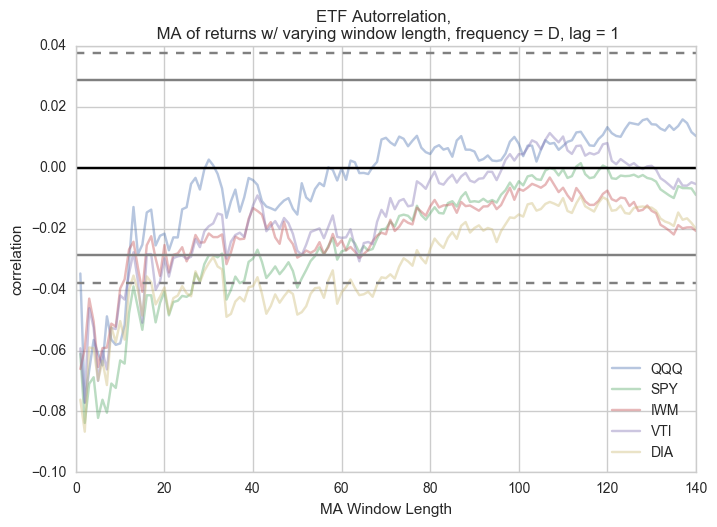

In [75]:
ac_ma_plot(end=140)

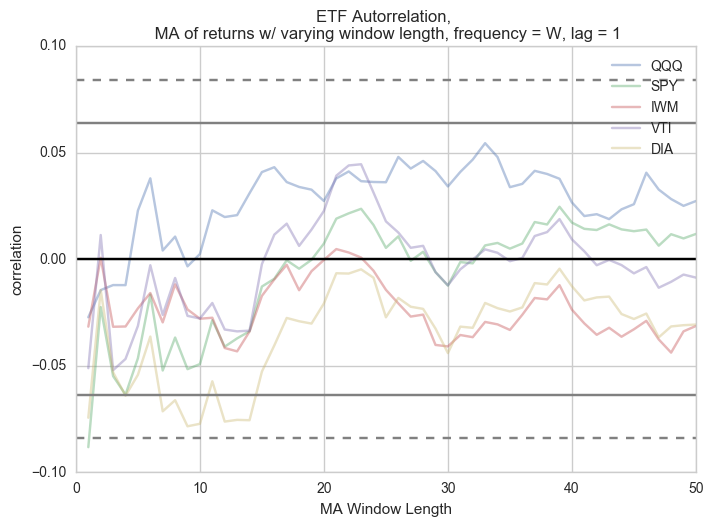

In [76]:
ac_ma_plot(end=50, freq='W')

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


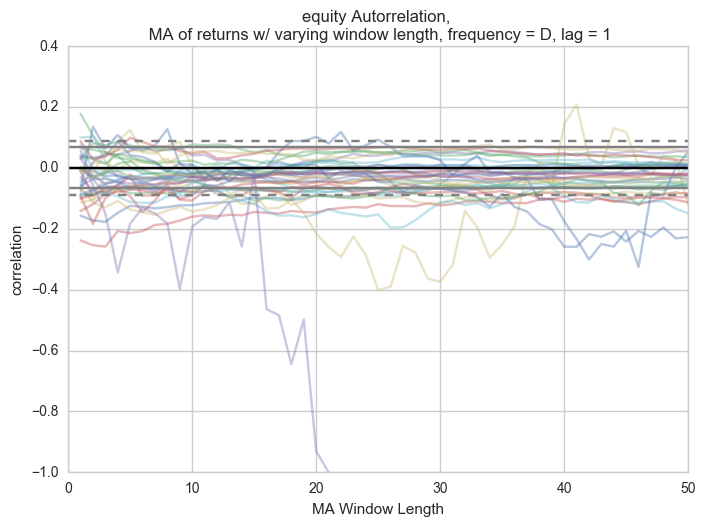

In [77]:
ac_ma_plot(asset_class='equity', end=50, freq='D',seed=9898)

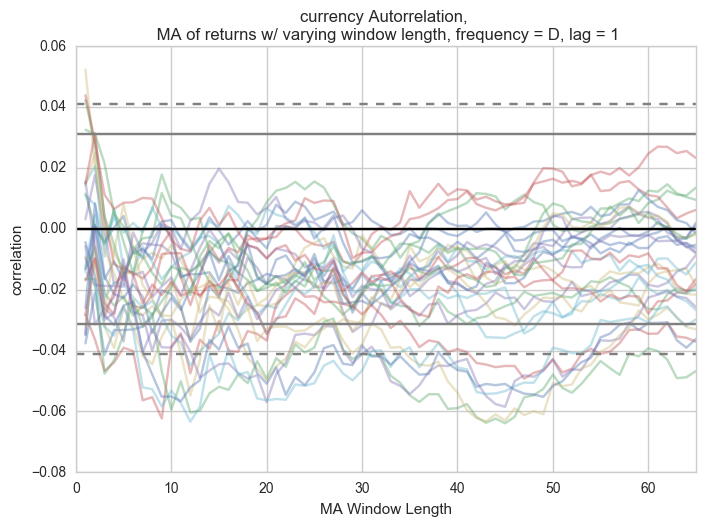

In [78]:
ac_ma_plot(asset_class='currency', end=65, freq='D')

## Currencies, Hour Time Frame

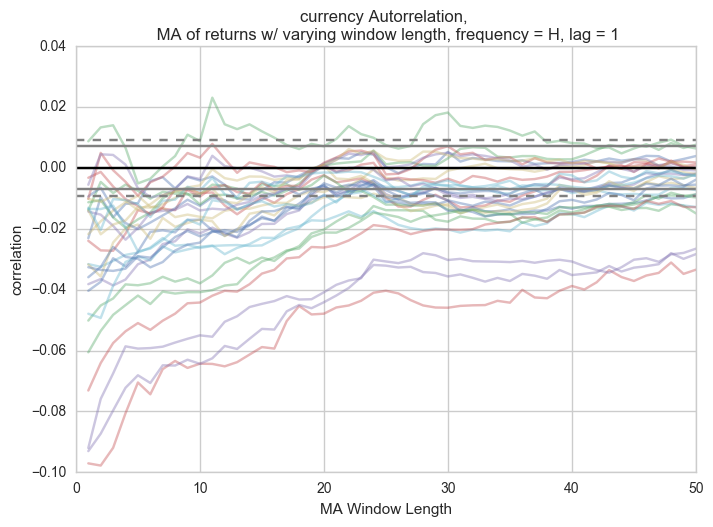

In [79]:
ac_ma_plot(asset_class='currency', end=50, freq='H')

## Currencies, Weekly Time Frame

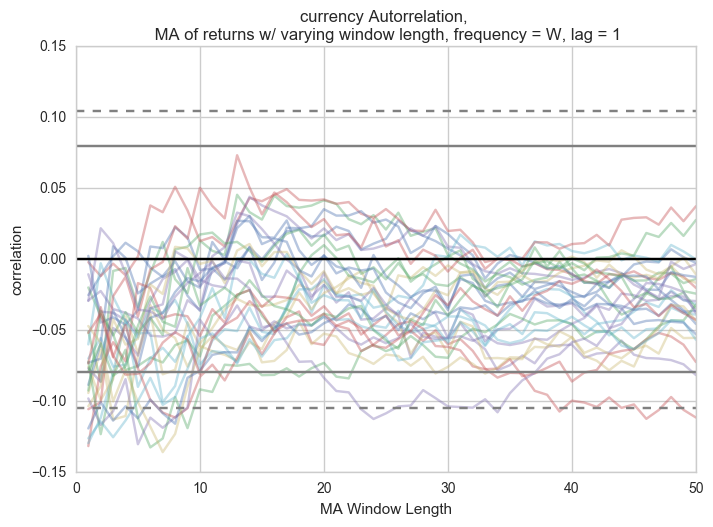

In [80]:
ac_ma_plot(asset_class='currency', end=50, freq='W')

## Autocorrelation Results

Here I have taken a few different looks at autocorrelation. The results are not particularly strong. The gray solid and dashed lines on the plot represent the $95\%$ and $99\%$ rejection regions, indicating the cutoff for significant values. If the lines fall within the region the the null hypothesis should be rejected; the null hypothesis being that the returns are __not__ autocorrelated. By definition, with multiple comparisons we would expected to see about $5\%$ of observations falling in the $95\%$ significance region and $1\%$ in the $99\%$ region only due to chance. For the most part the results seem to follow this pattern so there is nothing very significant. The only area which seems to show relatively convincing evidence would be autocorrelation with a lagging 1 to 3 day period at very short time frames such as the daily or weekly for ETFs and equities, then the hourly time frame for currencies. The most significant being the correlation of currency returns with a 1 day lagged, return moving average with a 1-10 day window.

In the cases where there may be a significant autocorrelative factor, the correlation appears to be negative. For example this means that if a lagging return or MA of returns in a given window indicateds positive returns, then the negative correlation predicts a next day with negative returns and vice versa. This would suggest a mean reverting property of returns. The actual correlation coefficient, however, is very small, -0.05 to -0.15 if it is significant at all. This value is so small it may not present a large enough opportunity to gain excess returns with a strategy which bets on the phenomenon.

# The Next Step

## Part 3:

The next step is taking the insights which I have gained from this work and writing an example trading algorithm. Please see the notebook for part 3.

# Not So Fast!

## Can anyone tell what is wrong with just about everything I did in this project?

## Survivorship Bias...
 - All of my equity data is for stock which were listed on the NYSE or NASDAQ on Jan 1, 2017.
 - I'm an undergrad with not cash for good data!

####  Why is this an issue?
 - Think of all the companies that have failed, gone bankrupt, been bought our, or been delisted.
     - not present in my data
     - These events and stock may in fact be the most relecant to the question I am trying to answer!
 - It might, however, be the case that these are for the most part negative fat tail events, which would only increase the signigicance of the results

# Not So Fast!

#### In addition, for the distribution fitting, I did not use hold out data.
 - I will be gather new data soon, for the period since I did this project
 - will test only this new data to see if the fit distributions still fit out of sample.

# Conclusion:

- Equity and currency market returns do not appear to be normally distributed
- A laplace distribution or T-distribution with 4-5 DF may be a better fit
- Fat tailed behavior is not likely due to autocorrelation
- **A follow up survivorship bias free study is need!**
    - This would give insight into just how prevelent and unnoticed the effects of survivorship bias are in financial analysis.